# CNN model with Bayesian Searched hyperparameter

We will be using this library for hyperparameter search with bayesian optimization method

pip install bayesian-optimization

        or

conda install -c conda-forge bayesian-optimization


In [1]:
%load_ext tensorboard
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv3D,MaxPool3D,Flatten,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.models import load_model, save_model
from tensorflow.keras.optimizers import Adam
!rm -rf ./logs/

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from os import path
import gc
import matplotlib
import nvgpu
import multiprocessing
import neptune
from functools import partial
from bayes_opt import BayesianOptimization
import csv

In [3]:
nvgpu.gpu_info()

[{'index': '0',
  'type': 'GeForce RTX 2070',
  'uuid': 'GPU-47d5adac-8dcb-1b2b-6564-70b959cdaa8f',
  'mem_used': 288,
  'mem_total': 7979,
  'mem_used_percent': 3.609474871537787}]

In [4]:
K.clear_session()
gc.collect()
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [5]:
train_alive = "/media/airadiomicslab/WINDOWS/RTOG_0617_DATA/NSCLC_0617_numpyImages/processed64_forall/alive"
train_dead = "/media/airadiomicslab/WINDOWS/RTOG_0617_DATA/NSCLC_0617_numpyImages/processed64_forall/dead"

In [14]:
def load_patient_images(input_path):
    np.load(input_path)
    return np.array(np.load(input_path))

In [20]:
alivelist = os.listdir(train_alive)
deadlist = os.listdir(train_dead)

In [21]:
path_list_alive = []
path_list_dead = []
for i in alivelist:
    path_list_alive.append(os.path.join(train_alive,i))
for i in deadlist:
    path_list_dead.append(os.path.join(train_dead,i))
    
labels_alive = np.zeros(len(alivelist))
labels_alive = list(labels_alive)
labels_dead = np.ones(len(deadlist))
labels_dead = list(labels_dead)

In [22]:
labels=[]
images = []

slices_alive = [load_patient_images(path_list_alive[s]) for s in range(0,len(path_list_alive))]
slices_dead = [load_patient_images(path_list_dead[k]) for k in range(0,len(path_list_dead))]

images.append(slices_alive.copy())
images[0].extend(slices_dead.copy())
images = np.array(images)
images = images[0,:,:,:,:]
slices_alive.clear()
slices_dead.clear()

labels.append(labels_alive.copy())
labels[0].extend(labels_dead.copy())
labels = np.array(labels)
labels = labels[0,:]
labels_alive.clear()
labels_dead.clear()

print(f"Labels Shape for input into CNN: {labels.shape}")
print(f"Data Shape for input into CNN: {images.shape}")
gc.collect()

Labels Shape for input into CNN: (428,)
Data Shape for input into CNN: (428, 64, 64, 64)


384

In [23]:
xtrain, xtest, ytrain, ytest = train_test_split(images, labels, test_size = 0.2)

In [24]:
print(f"Shape for Training Set is: {xtrain.shape} and corrsponding labels shape is: {ytrain.shape} ")
print(f"Shape for Test Set is:     {xtest.shape} and corrsponding labels shape is:  {ytest.shape} ")

Shape for Training Set is: (342, 64, 64, 64) and corrsponding labels shape is: (342,) 
Shape for Test Set is:     (86, 64, 64, 64) and corrsponding labels shape is:  (86,) 


In [25]:
xtrain = xtrain.reshape(len(xtrain),64,64,64,1)
xtest = xtest.reshape(len(xtest),64,64,64,1)

print(f"New Shape for Training data required for MODEL is: {xtrain.shape} ")
print(f"New Shape for Test data is: required for MODEL is: {xtest.shape} ")

New Shape for Training data required for MODEL is: (342, 64, 64, 64, 1) 
New Shape for Test data is: required for MODEL is: (86, 64, 64, 64, 1) 


In [26]:
xtrain = xtrain.astype(dtype='float32')
xtest = xtest.astype(dtype='float32')

In [27]:
ytrain = ytrain.astype(dtype='uint8')
ytest = ytest.astype(dtype='uint8')

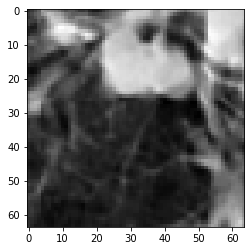

In [28]:
plt.imshow(xtrain[15][:,:,32,0],cmap='gray')

In [29]:
K.clear_session()
gc.collect()

122

In [30]:
filepathAcc = "/home/airadiomicslab/OneDrive/BayesianModels/RTOGBayesianBestAccModel.hdf5"
filepathLoss = "/home/airadiomicslab/OneDrive/BayesianModels/RTOGBayesianBestLossModel.hdf5"
checkpointAcc = [ModelCheckpoint(filepathAcc,monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')]
checkpointLoss = [ModelCheckpoint(filepathLoss,monitor='val_loss',verbose=1,save_best_only=True,mode='min')]
early_stop = [EarlyStopping(monitor='val_loss',patience=10)]
callback_list = [early_stop,checkpointAcc,checkpointLoss]

In [31]:
image_shape=(64,64,64,1)

In [32]:
path2SaveModel = "/home/airadiomicslab/OneDrive/RTOGModels/"
path2SaveError = "/home/airadiomicslab/OneDrive/RTOGRunErrors/"

In [39]:
def QARCEsoModel(batch_size,learning_rate,L2_2,L2_3,BNConv1,BNConv2,BNDense1,
                 BNDense2,BNDense3):
    
    model = Sequential() 
    model.add(Conv3D(filters=16,kernel_size=(5,7,5),strides=(1,1,1),padding='same',
                     input_shape=image_shape, activation='relu',name='Conv3D_InputLayer')) 
    model.add(MaxPool3D(pool_size=(2,3,2),name='MaxPool4InputLayer'))

    if L2_2:
        L2_2 = 0.01
    else:
        L2_2 = 0.001
        
    model.add(Conv3D(filters=32,kernel_size=(3,3,3),strides=(1,1,1),
                     padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2_2),activation='relu',
                     name='Conv3D_FirstLayer'))
    model.add(MaxPool3D(pool_size=(2,3,2),name='MaxPool4FirstLayer'))
    if BNConv1:
        model.add(BatchNormalization())
    model.add(Dropout(0.2))
    
    if L2_3:
        L2_3= 0.01
    else:
        L2_3 = 0.001

    model.add(Conv3D(filters=128,kernel_size=(3,3,3),strides=(1,1,1),
                     padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2_3),activation='relu',
                     name='Conv3D_SecondLayer'))
    model.add(MaxPool3D(pool_size=(3,3,3),name='MaxPool4SecondLayer'))
    if BNConv2:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))


    model.add(Flatten())

    model.add(Dense(512,activation='relu'))
    if BNDense1:
        model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(256,activation='relu'))
    if BNDense2:
        model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128,activation='relu'))
    if BNDense3:
        model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(1,activation='sigmoid'))
    
    if learning_rate == 0:
        learning_rate = 0.01
    elif learning_rate == 1:
        learning_rate = 0.001
    elif learning_rate == 2:
        learning_rate = 0.0001
    elif learning_rate == 3:
        learning_rate = 0.00001
    else:
        learning_rate = 0.000001
        
    optimizer = Adam(learning_rate = learning_rate, name='Adam')

    model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    # INSERT CHECKPOINT FOR SAVING MODEL
    model.fit(xtrain,ytrain,batch_size=batch_size,epochs=1000,validation_data=(xtest,ytest),
              steps_per_epoch=xtrain.shape[0]//batch_size,
              callbacks=early_stop,verbose=1,shuffle=True)
    _, accuracy = model.evaluate(xtest,ytest,batch_size=8)
    return accuracy,model

In [40]:
def generate_cnn(batch_size,learning_rate,L2_2,L2_3,BNConv1,BNConv2,BNDense1,BNDense2,BNDense3):
    global session_num
    global last_acc
    # define parameters
    params = {
        'batch_size': int(np.around(batch_size)),
        'learning_rate' :  int(np.around(learning_rate)),
        'L2_2' : int(np.around(L2_2)),
        'L2_3' : int(np.around(L2_3)),
        'BNConv1' : int(np.around(BNConv1)),
        'BNConv2' : int(np.around(BNConv2)),
        'BNDense1' : int(np.around(BNDense1)),
        'BNDense2' : int(np.around(BNDense2)),
        'BNDense3' : int(np.around(BNDense3))
    }
    run_name = "run-%d" % session_num
    session_num +=1
    print('--- Starting trial: %s' % run_name)
    #print({params.name: params[h] for h in params})
    for value in params:
        print(f'Parameter values for this run are {value}: {params[value]}')
    try:
        # select project
        #neptune.set_project('kundan25/EsoCRPredictionBaysian') # NOT SURE TO USE IT OR NOT
        #neptune.init('kundan25/EsoCRPredictionBaysian')
        with neptune.create_experiment(name='RTOG0617ModelRun1',params=params) as BayesianOptimizer:
            valid_acc,model = QARCEsoModel(**params)
            last_acc = valid_acc
            if (valid_acc > 0.95):
                save_model(model,filepath=path2SaveModel+'bestmodel95' + run_name +'.hdf5')
                BayesianOptimizer.append_tag('BestAcc95')
            elif (valid_acc > 0.90):
                save_model(model,filepath=path2SaveModel+'bestmodel90' + run_name +'.hdf5')
                BayesianOptimizer.append_tag('BestAcc90')
            elif (valid_acc > 0.85):
                save_model(model,filepath=path2SaveModel+'bestmodel85' + run_name +'.hdf5')
                BayesianOptimizer.append_tag('BestAcc85')
            elif (valid_acc > 0.80):
                save_model(model,filepath=path2SaveModel+'bestmodel80' + run_name +'.hdf5')
                BayesianOptimizer.append_tag('BestAcc80')
            for i in model.history.history['accuracy']:
                BayesianOptimizer.log_metric('Training Accuracy', i)
                BayesianOptimizer.log_metric('Max_Training_Accuracy', max(model.history.history['accuracy']))
            for i in model.history.history['val_accuracy']:
                BayesianOptimizer.log_metric('Validation_Accuracy', i)
                BayesianOptimizer.log_metric('Max Val_Accuracy', max(model.history.history['val_accuracy']))
            for i in model.history.history['loss']:
                BayesianOptimizer.log_metric('Training Loss', i)
                BayesianOptimizer.log_metric('Min Training_Loss', min(model.history.history['loss']))
            for i in model.history.history['val_loss']:
                BayesianOptimizer.log_metric('Validation Loss', i)
                BayesianOptimizer.log_metric('Min Val_Loss', min(model.history.history['val_loss']))
            tf.keras.backend.clear_session()
    except tf.errors.ResourceExhaustedError as e:
        print('RESOURCE GOT EXHAUSTED')
        with open(path2SaveError + "ErrParams"+ run_name + ".csv","a") as csv_file:
            csv_writer = csv.writer(csv_file)
            for key,value in params.items():
                csv_writer.writerow([key,value])
        csv_file.close()
        session_num += 1
        valid_acc = last_acc
        tf.keras.backend.clear_session()    
    return valid_acc

In [41]:
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events

In [42]:
pbounds = {'batch_size': (4,16),'learning_rate': (0, 4),'L2_2': (0, 1),'L2_3': (0, 1),
           'BNConv1': (0, 1),'BNConv2': (0, 1),'BNDense1': (0, 1),'BNDense2': (0, 1),'BNDense3': (0, 1)
         }
CNN_BAYESIAN = BayesianOptimization(generate_cnn,pbounds=pbounds,verbose=2)

In [43]:
logger = JSONLogger(path="/home/airadiomicslab/OneDrive/logs/RTOGBayesianlogs.json")
CNN_BAYESIAN.subscribe(Events.OPTIMIZATION_STEP, logger)

In [44]:
api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiM2M5MDk2YWItYzRiMS00MThlLTljZTctMDFmNDJkYWIwZmU5In0="

In [45]:
session_num = 1
neptune.init('kundan25/RTOG0617',api_token=api_token)
neptune.set_project('kundan25/RTOG0617')
init_points = 25
n_iter = 2000
with neptune.create_experiment(name='BayesianRun1',params=pbounds) as BayesianRunOptimizer:
    CNN_BAYESIAN.maximize(init_points = init_points, n_iter = n_iter, acq = 'ei', xi = 0.0)
    BayesianRunOptimizer.append_tag('BayesianOptimizerRun')

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1
--- Starting trial: run-1
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-2
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 5ms/sample - loss: 2.2567 - accuracy: 0.3140al_loss: 2.2567 - val_accuracy
--- Starting trial: run-2
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run ar

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-3
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-4
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6060 - accuracy: 0.3372al_loss: 1.6060 - val_accuracy: 
--- Starting trial: run-4
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are 

86/86 [==============================] - 0s 2ms/sample - loss: 1.2511 - accuracy: 0.4419al_loss: 1.2511 - val_accuracy: 
--- Starting trial: run-6
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-7
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 0.9176 - accuracy: 0.5263 - val_loss: 0.7691 - val_accuracy: 0.4767
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8695 - accuracy: 0.5351 - val_loss: 0.7290 - val_accuracy: 0.6744
Epoch 3/1000
342/342 [==============================] -

86/86 [==============================] - 0s 2ms/sample - loss: 1.2692 - accuracy: 0.6860al_loss: 1.2692 - val_accuracy: 
--- Starting trial: run-8
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-9
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.9603 - accuracy: 0.6744al_loss: 1.9603 - val_accuracy: 
--- Starting trial: run-9
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Para

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-10
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-11
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3991 - accuracy: 0.6860al_loss: 1.3991 - val_accuracy: 
--- Starting trial: run-11
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run a

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-12
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-13
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6650 - accuracy: 0.6860al_loss: 0.6650 - val_accuracy: 
--- Starting trial: run-13
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-14
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-15
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-15
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-16
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7151 - accuracy: 0.6512al_loss: 0.7151 - val_accuracy: 
--- Starting trial: run-16
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-18
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-19
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2417 - accuracy: 0.3140al_loss: 1.2417 - val_accuracy: 
--- Starting trial: run-19
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-21
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-22
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7269 - accuracy: 0.6512al_loss: 0.7269 - val_accuracy: 
--- Starting trial: run-22
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run ar

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-23
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-24
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7938 - accuracy: 0.5814al_loss: 0.7938 - val_accuracy: 
--- Starting trial: run-24
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: 1.2002 - accuracy: 0.5698al_loss: 1.2002 - val_accuracy: 
--- Starting trial: run-26
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-27
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0302 - accuracy: 0.6744al_loss: 1.0302 - val_accuracy: 
--- Starting trial: run-27
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
P

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-28
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-29
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-29
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-30
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8888 - accuracy: 0.6860al_loss: 0.8888 - val_accuracy: 
--- Starting trial: run-30
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run a

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-31
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-32
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-32
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-33
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4261 - accuracy: 0.4419al_loss: 1.4261 - val_accuracy: 
--- Starting trial: run-33
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run a

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-35
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9657 - accuracy: 0.6860al_loss: 0.9657 - val_accuracy: 
--- Starting trial: run-35
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-36
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7729 - accuracy: 0.3837al_loss: 0.7729 - val_accuracy: 
--- Starting trial: run-36
Parameter values for this run are batch_size: 15
Parameter values for this r

86/86 [==============================] - 0s 2ms/sample - loss: 1.5444 - accuracy: 0.6047al_loss: 1.5444 - val_accuracy: 
--- Starting trial: run-38
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-39
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7156 - accuracy: 0.6860al_loss: 0.7156 - val_accuracy: 
--- Starting trial: run-39
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0


86/86 [==============================] - 0s 2ms/sample - loss: 0.7512 - accuracy: 0.6860al_loss: 0.7512 - val_accuracy: 
--- Starting trial: run-41
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-42
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7852 - accuracy: 0.4884al_loss: 0.7852 - val_accuracy: 
--- Starting trial: run-42
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
P

86/86 [==============================] - 0s 2ms/sample - loss: 0.6933 - accuracy: 0.6860al_loss: 0.6933 - val_accuracy: 
--- Starting trial: run-43
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-44
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2448 - accuracy: 0.6860al_loss: 1.2448 - val_accuracy: 
--- Starting trial: run-44
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0


86/86 [==============================] - 0s 2ms/sample - loss: 0.8484 - accuracy: 0.3140al_loss: 0.8484 - val_accuracy: 
--- Starting trial: run-45
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-46
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 1.2727 - accuracy: 0.5427 - val_loss: 1.1271 - val_accuracy: 0.6860Epoch 46/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-46
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-47
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9378 - accuracy: 0.4884al_loss: 0.9378 - val_accuracy: 
--- Starting trial: run-47
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run a

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-48
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-49
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.1096 - accuracy: 0.5351 - val_loss: 0.9805 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0467 - accuracy: 0.5994 - val_loss: 0.9762 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0087 - accuracy: 0.5936 - val_loss: 0.9869 - val_accuracy: 0.3023
Epoch 4/1000
342/342 [======

86/86 [==============================] - 0s 2ms/sample - loss: 0.6475 - accuracy: 0.6860al_loss: 0.6475 - val_accuracy: 
--- Starting trial: run-50
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-51
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-51
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-52
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-52
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-53
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8828 - accuracy: 0.6860al_loss: 0.8828 - val_accuracy: 
--- Starting trial: run-53
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run a

330/342 [===========================>..] - ETA: 0s - loss: 0.7799 - accuracy: 0.5606 - val_loss: 0.7402 - val_accuracy: 0.6860Epoch 97/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7351 - accuracy: 0.6860al_loss: 0.7351 - val_accuracy: 
--- Starting trial: run-54
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-55
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.6788 - accuracy: 0.5888 - val_loss: 0.6419 - val_accuracy: 0.6860Epoch 50/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9314 - accuracy: 0.6860al_loss: 0.9314 - val_accuracy: 
--- Starting trial: run-55
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-56
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-56
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-57
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6504 - accuracy: 0.6860al_loss: 0.6504 - val_accuracy: 
--- Starting trial: run-57
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are

342/342 [==============================] - 3s 9ms/sample - loss: 1.0890 - accuracy: 0.5058 - val_loss: 0.9436 - val_accuracy: 0.5814
Epoch 14/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0610 - accuracy: 0.5526 - val_loss: 0.9411 - val_accuracy: 0.5814
Epoch 15/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0944 - accuracy: 0.4942 - val_loss: 0.9424 - val_accuracy: 0.5930
Epoch 16/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0216 - accuracy: 0.5760 - val_loss: 0.9402 - val_accuracy: 0.6047
Epoch 17/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0485 - accuracy: 0.5234 - val_loss: 0.9413 - val_accuracy: 0.6047
Epoch 18/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0478 - accuracy: 0.5760 - val_loss: 0.9423 - val_accuracy: 0.6047
Epoch 19/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0510 - accuracy: 0.5468 - val_loss: 0.9470 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-60
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-61
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-61
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-62
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9556 - accuracy: 0.6860al_loss: 0.9556 - val_accuracy: 
--- Starting trial: run-62
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: 0.9880 - accuracy: 0.6860al_loss: 0.9880 - val_accuracy: 
--- Starting trial: run-63
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-64
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4364 - accuracy: 0.3488al_loss: 1.4364 - val_accuracy
--- Starting trial: run-64
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Pa

86/86 [==============================] - 0s 2ms/sample - loss: 0.9285 - accuracy: 0.6512al_loss: 0.9285 - val_accuracy: 
--- Starting trial: run-65
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-66
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 13ms/sample - loss: 1.7321 - accuracy: 0.4181 - val_loss: 1.3046 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.7588 - accuracy: 0.3977 - val_loss: 1.3400 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [==============================]

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-68
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-69
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1904 - accuracy: 0.6279al_loss: 1.1904 - val_accuracy: 
--- Starting trial: run-69
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-71
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-72
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8930 - accuracy: 0.6744al_loss: 0.8930 - val_accuracy: 
--- Starting trial: run-72
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are

Epoch 27/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7382 - accuracy: 0.5877 - val_loss: 0.6922 - val_accuracy: 0.6860
Epoch 28/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7229 - accuracy: 0.5877 - val_loss: 0.6798 - val_accuracy: 0.6860
Epoch 29/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7148 - accuracy: 0.5877 - val_loss: 0.6768 - val_accuracy: 0.6860
Epoch 30/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7113 - accuracy: 0.5877 - val_loss: 0.6731 - val_accuracy: 0.6860
Epoch 31/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7048 - accuracy: 0.5877 - val_loss: 0.6696 - val_accuracy: 0.6860
Epoch 32/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7142 - accuracy: 0.5877 - val_loss: 0.7016 - val_accuracy: 0.6860
Epoch 33/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7232 - accuracy: 0.5877 - val_loss: 0

Epoch 83/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6782 - accuracy: 0.5877 - val_loss: 0.6426 - val_accuracy: 0.6860
Epoch 84/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6786 - accuracy: 0.5877 - val_loss: 0.6427 - val_accuracy: 0.6860
Epoch 85/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6787 - accuracy: 0.5877 - val_loss: 0.6450 - val_accuracy: 0.6860
Epoch 86/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6784 - accuracy: 0.5877 - val_loss: 0.6414 - val_accuracy: 0.6860
Epoch 87/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6421 - accuracy: 0.6860
--- Starting trial: run-73
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-76
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-77
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4359 - accuracy: 0.3488al_loss: 1.4359 - val_accuracy: 
--- Starting trial: run-77
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-78
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-79
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6596 - accuracy: 0.6860al_loss: 0.6596 - val_accuracy: 
--- Starting trial: run-79
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: 1.3937 - accuracy: 0.6163al_loss: 1.3937 - val_accuracy: 
--- Starting trial: run-80
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-81
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 2.1708 - accuracy: 0.6860al_loss: 2.1708 - val_accuracy: 
--- Starting trial: run-81
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
P

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-82
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-83
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6639 - accuracy: 0.3372al_loss: 1.6639 - val_accuracy
--- Starting trial: run-83
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are B

337/342 [============================>.] - ETA: 0s - loss: 0.8096 - accuracy: 0.5371 - val_loss: 0.7499 - val_accuracy: 0.6744Epoch 99/1000


337/342 [============================>.] - ETA: 0s - loss: 0.7181 - accuracy: 0.5964 - val_loss: 0.7242 - val_accuracy: 0.5581Epoch 157/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7037 - accuracy: 0.6047al_loss: 0.7037 - val_accuracy: 
--- Starting trial: run-84
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-85
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-85
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-86
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4706 - accuracy: 0.3023al_loss: 1.4706 - val_accuracy
--- Starting trial: run-86
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are B

86/86 [==============================] - 0s 2ms/sample - loss: 1.1979 - accuracy: 0.6163al_loss: 1.1979 - val_accuracy: 
--- Starting trial: run-88
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-89
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 0.8185 - accuracy: 0.5727 - val_loss: 0.7339 - val_accuracy: 0.6860Epoch 15/1000


86/86 [==============================] - 0s 3ms/sample - loss: 0.6767 - accuracy: 0.6860al_loss: 0.6767 - val_accuracy
--- Starting trial: run-89
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-90
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 5s 14ms/sample - loss: 2.1399 - accuracy: 0.5585 - val_loss: 14.8713 - val_accuracy: 0.3372
Epoch 2/1000
342/342 [==============================] - 4s 10ms/sample - loss: 1.5491 - accuracy: 0.4942 - val_loss: 1.8497 - val_accuracy: 0.3256
Epoch 3/1000
342/342 [==============================]

86/86 [==============================] - 0s 3ms/sample - loss: 0.9421 - accuracy: 0.6279al_loss: 0.9421 - val_accuracy
--- Starting trial: run-91
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-92
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.3307 - accuracy: 0.6860al_loss: 1.3307 - val_accuracy
--- Starting trial: run-92
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Param

86/86 [==============================] - 0s 2ms/sample - loss: 1.6728 - accuracy: 0.6860al_loss: 1.6728 - val_accuracy: 
--- Starting trial: run-94
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-95
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-95
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-96
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-96
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-97
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9330 - accuracy: 0.6163al_loss: 0.9330 - val_accuracy: 
--- Starting trial: run-97
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-99
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-100
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0443 - accuracy: 0.6047al_loss: 1.0443 - val_accuracy: 
--- Starting trial: run-100
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 1.3204 - accuracy: 0.6860al_loss: 1.3204 - val_accuracy: 
--- Starting trial: run-101
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-102
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2085 - accuracy: 0.6163al_loss: 1.2085 - val_accuracy: 
--- Starting trial: run-102
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 3ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-104
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-105
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9186 - accuracy: 0.6395al_loss: 0.9186 - val_accuracy
--- Starting trial: run-105
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run a

Epoch 22/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0149 - accuracy: 0.5877 - val_loss: 0.9868 - val_accuracy: 0.6860
Epoch 23/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9136 - accuracy: 0.5819 - val_loss: 0.8171 - val_accuracy: 0.6860
Epoch 24/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8231 - accuracy: 0.5819 - val_loss: 0.7569 - val_accuracy: 0.6860
Epoch 25/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7789 - accuracy: 0.5848 - val_loss: 0.7248 - val_accuracy: 0.6860
Epoch 26/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7519 - accuracy: 0.5877 - val_loss: 0.7033 - val_accuracy: 0.6860
Epoch 27/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7276 - accuracy: 0.5877 - val_loss: 0.6829 - val_accuracy: 0.6860
Epoch 28/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7104 - accuracy: 0.5877 - val_loss: 0

86/86 [==============================] - 0s 2ms/sample - loss: 1.0005 - accuracy: 0.5233al_loss: 1.0005 - val_accuracy
--- Starting trial: run-108
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-109
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9148 - accuracy: 0.6860al_loss: 0.9148 - val_accuracy: 
--- Starting trial: run-109
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1


https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-111
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7407 - accuracy: 0.6860al_loss: 0.7407 - val_accuracy: 
--- Starting trial: run-111
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-112
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 0.8797 - accuracy: 0.6353 - val_loss: 0.8819 - val_accuracy: 0.6395Epoch 21/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9550 - accuracy: 0.6047al_loss: 0.9550 - val_accuracy: 
--- Starting trial: run-112
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-113
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-113
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-114
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5357 - accuracy: 0.3140al_loss: 1.5357 - val_accuracy
--- Starting trial: run-114
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 1.1507 - accuracy: 0.6977al_loss: 1.1704 - val_accuracy: 
--- Starting trial: run-116
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-117
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-117
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-118
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2400 - accuracy: 0.4535al_loss: 1.2400 - val_accuracy: 
--- Starting trial: run-118
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.1603 - accuracy: 0.6860al_loss: 1.1603 - val_accuracy: 
--- Starting trial: run-120
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-121
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 3.4366 - accuracy: 0.4883 - val_loss: 4.7884 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.9448 - accuracy: 0.5673 - val_loss: 1.3112 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

Epoch 8/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8897 - accuracy: 0.5643 - val_loss: 0.7572 - val_accuracy: 0.6860
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8817 - accuracy: 0.5322 - val_loss: 0.7477 - val_accuracy: 0.6860
Epoch 10/1000
342/342 [==============================] - 3s 7ms/sample - loss: 0.9455 - accuracy: 0.4971 - val_loss: 0.7585 - val_accuracy: 0.6860
Epoch 11/1000
86/86 [==============================] - 0s 3ms/sample - loss: 0.7284 - accuracy: 0.6860
--- Starting trial: run-122
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-123
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-124
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.2937 - accuracy: 0.5000 - val_loss: 26.3734 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1779 - accuracy: 0.5439 - val_loss: 1.2378 - val_accuracy: 0.5698
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1410 - accuracy: 0.5439 - val_loss: 1.0707 - val_accuracy: 0.6977
Epoch 4/1000
342/342 [===

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-125
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-126
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-126
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-127
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.2121 - accuracy: 0.5058 - val_loss: 0.9322 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2054 - accuracy: 0.5146 - val_loss: 0.8852 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0933 - accuracy: 0.5702 - val_loss: 0.9157 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-128
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-129
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6644 - accuracy: 0.6860al_loss: 0.6644 - val_accuracy: 
--- Starting trial: run-129
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-131
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8860 - accuracy: 0.4535al_loss: 0.8860 - val_accuracy: 
--- Starting trial: run-131
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-132
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-132
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-133
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-133
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-134
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2473 - accuracy: 0.6744al_loss: 1.2473 - val_accuracy: 
--- Starting trial: run-134
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

332/342 [============================>.] - ETA: 0s - loss: 0.8499 - accuracy: 0.5843 - val_loss: 0.8163 - val_accuracy: 0.6860Epoch 73/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8107 - accuracy: 0.6860al_loss: 0.8107 - val_accuracy: 
--- Starting trial: run-135
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-136
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.6952 - accuracy: 0.5621 - val_loss: 0.6518 - val_accuracy: 0.6860Epoch 31/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6396 - accuracy: 0.6860al_loss: 0.6396 - val_accuracy
--- Starting trial: run-136
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-137
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9204 - accuracy: 0.6047al_loss: 0.9204 - val_accuracy: 
--- Starting trial: run-137
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
P

86/86 [==============================] - 0s 2ms/sample - loss: 0.7666 - accuracy: 0.5581al_loss: 0.7666 - val_accuracy: 
--- Starting trial: run-139
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-140
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.0452 - accuracy: 0.5643 - val_loss: 0.9732 - val_accuracy: 0.3372
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9873 - accuracy: 0.5936 - val_loss: 1.0039 - val_accuracy: 0.3488
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 1.2494 - accuracy: 0.4419al_loss: 1.2494 - val_accuracy: 
--- Starting trial: run-141
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-142
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.4996 - accuracy: 0.4503 - val_loss: 1.2588 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4604 - accuracy: 0.4971 - val_loss: 1.2331 - val_accuracy: 0.3256
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 2s 7ms/sample - loss: 1.0597 - accuracy: 0.5789 - val_loss: 0.9618 - val_accuracy: 0.6628
Epoch 51/1000
342/342 [==============================] - 3s 7ms/sample - loss: 1.0826 - accuracy: 0.5497 - val_loss: 0.9572 - val_accuracy: 0.6744
Epoch 52/1000
342/342 [==============================] - 3s 7ms/sample - loss: 1.0568 - accuracy: 0.5906 - val_loss: 0.9561 - val_accuracy: 0.6744
Epoch 53/1000
342/342 [==============================] - 3s 7ms/sample - loss: 1.0395 - accuracy: 0.5643 - val_loss: 0.9536 - val_accuracy: 0.6744
Epoch 54/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0772 - accuracy: 0.5439 - val_loss: 0.9478 - val_accuracy: 0.6744
Epoch 55/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0570 - accuracy: 0.5585 - val_loss: 0.9475 - val_accuracy: 0.6395
Epoch 56/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0360 - accuracy: 0.5526 - val_loss: 0.9434 - val_ac

Epoch 106/1000
342/342 [==============================] - 3s 7ms/sample - loss: 0.8293 - accuracy: 0.6082 - val_loss: 0.8301 - val_accuracy: 0.6047
Epoch 107/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8623 - accuracy: 0.5760 - val_loss: 0.8272 - val_accuracy: 0.6279
Epoch 108/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8197 - accuracy: 0.6279
--- Starting trial: run-142
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-143
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sam

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-145
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7604 - accuracy: 0.6163al_loss: 0.7604 - val_accuracy: 
--- Starting trial: run-145
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-146
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 5.9332 - accuracy: 0.5698val_loss: 5.9332 - val_accuracy: 
--- Starting trial: run-146
Parameter values for this run are batch_size: 11
Parameter values for t

86/86 [==============================] - 0s 2ms/sample - loss: 1.6947 - accuracy: 0.5814al_loss: 1.6947 - val_accuracy: 
--- Starting trial: run-147
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-148
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1824 - accuracy: 0.5349al_loss: 1.1824 - val_accuracy: 
--- Starting trial: run-148
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.5619 - accuracy: 0.3140al_loss: 1.5619 - val_accuracy: 
--- Starting trial: run-150
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-151
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-151
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-152
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4498 - accuracy: 0.3372al_loss: 1.4498 - val_accuracy: 
--- Starting trial: run-152
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7094 - accuracy: 0.6860al_loss: 0.7094 - val_accuracy: 
--- Starting trial: run-154
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-155
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9616 - accuracy: 0.5930al_loss: 0.9616 - val_accuracy: 
--- Starting trial: run-155
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7441 - accuracy: 0.6860al_loss: 0.7441 - val_accuracy: 
--- Starting trial: run-156
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-157
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-157
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-158
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0754 - accuracy: 0.5698al_loss: 1.0754 - val_accuracy: 
--- Starting trial: run-158
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.0334 - accuracy: 0.4186al_loss: 1.0334 - val_accuracy: 
--- Starting trial: run-159
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-160
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7808 - accuracy: 0.6860al_loss: 0.7808 - val_accuracy: 
--- Starting trial: run-160
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7621 - accuracy: 0.4651al_loss: 0.7621 - val_accuracy: 
--- Starting trial: run-161
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-162
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 3.2020 - accuracy: 0.3140al_loss: 3.2020 - val_accuracy: 
--- Starting trial: run-162
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.3730 - accuracy: 0.4419al_loss: 1.3730 - val_accuracy: 
--- Starting trial: run-164
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-165
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9310 - accuracy: 0.6163al_loss: 1.1594 - val_accuracy: 
--- Starting trial: run-165
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7202 - accuracy: 0.6744al_loss: 0.7202 - val_accuracy: 
--- Starting trial: run-166
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-167
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7264 - accuracy: 0.6860al_loss: 0.7264 - val_accuracy: 
--- Starting trial: run-167
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-169
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0275 - accuracy: 0.5698al_loss: 1.0275 - val_accuracy: 
--- Starting trial: run-169
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-170
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6395 - accuracy: 0.6628al_loss: 1.6395 - val_accuracy: 
--- Starting trial: run-170
Parameter values for this run are batch_size: 16
Parameter values for th

86/86 [==============================] - 0s 2ms/sample - loss: 0.8465 - accuracy: 0.6860al_loss: 0.8465 - val_accuracy: 
--- Starting trial: run-172
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-173
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7013 - accuracy: 0.6860al_loss: 0.7013 - val_accuracy: 
--- Starting trial: run-173
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7378 - accuracy: 0.6860al_loss: 0.7378 - val_accuracy: 
--- Starting trial: run-174
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-175
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-175
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-176
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-176
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-177
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6445 - accuracy: 0.6860al_loss: 0.6445 - val_accuracy: 
--- Starting trial: run-177
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 1.4205 - accuracy: 0.4651al_loss: 1.4205 - val_accuracy: 
--- Starting trial: run-179
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-180
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8193 - accuracy: 0.6860al_loss: 0.8193 - val_accuracy: 
--- Starting trial: run-180
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7191 - accuracy: 0.6860al_loss: 0.7191 - val_accuracy: 
--- Starting trial: run-181
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-182
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 2.7955 - accuracy: 0.5029 - val_loss: 1.3755 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2328 - accuracy: 0.5585 - val_loss: 1.0487 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 1.8125 - accuracy: 0.3953al_loss: 1.8125 - val_accuracy: 
--- Starting trial: run-183
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-184
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-184
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-185
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0893 - accuracy: 0.6628al_loss: 0.8159 - val_accuracy
--- Starting trial: run-185
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 1.5032 - accuracy: 0.4186al_loss: 1.5032 - val_accuracy: 
--- Starting trial: run-186
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-187
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7187 - accuracy: 0.6860al_loss: 0.7187 - val_accuracy
--- Starting trial: run-187
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-188
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-189
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9102 - accuracy: 0.6628al_loss: 0.9102 - val_accuracy
--- Starting trial: run-189
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-191
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-192
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7567 - accuracy: 0.5930al_loss: 0.7567 - val_accuracy: 
--- Starting trial: run-192
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-194
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 6.7747 - accuracy: 0.5760 - val_loss: 7.3214 - val_accuracy: 0.3953
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 3.7339 - accuracy: 0.5292 - val_loss: 2.6982 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 2.1723 - accuracy: 0.5585 - val_loss: 1.7382 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.5210 - accuracy: 0.5760 - val_loss: 1.3148 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.2315 - accuracy: 0.5819 - val_loss: 1.1328 - val_accuracy: 0.6744
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0909 - accuracy: 0.5848 - val_loss: 0.9851 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [=====

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-195
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-196
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6485 - accuracy: 0.6860al_loss: 0.6485 - val_accuracy: 
--- Starting trial: run-196
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-197
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-198
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 10ms/sample - loss: 7.8343 - accuracy: 0.5731 - val_loss: 1.4425 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.3827 - accuracy: 0.5877 - val_loss: 1.2643 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.2217 - accuracy: 0.5877 - val_loss: 1.1170 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

342/342 [==============================] - 3s 8ms/sample - loss: 0.6833 - accuracy: 0.5877 - val_loss: 0.6486 - val_accuracy: 0.6860
Epoch 54/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6830 - accuracy: 0.5877 - val_loss: 0.6482 - val_accuracy: 0.6860
Epoch 55/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6828 - accuracy: 0.5877 - val_loss: 0.6474 - val_accuracy: 0.6860
Epoch 56/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6821 - accuracy: 0.5877 - val_loss: 0.6474 - val_accuracy: 0.6860
Epoch 57/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6820 - accuracy: 0.5877 - val_loss: 0.6478 - val_accuracy: 0.6860
Epoch 58/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6831 - accuracy: 0.5877 - val_loss: 0.6460 - val_accuracy: 0.6860
Epoch 59/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6816 - accuracy: 0.5877 - val_loss: 0.6438 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: 0.8573 - accuracy: 0.6860al_loss: 0.8573 - val_accuracy: 
--- Starting trial: run-200
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-201
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 1.2641 - accuracy: 0.5657 - val_loss: 1.1762 - val_accuracy: 0.6860Epoch 21/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-201
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-202
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 0.7694 - accuracy: 0.5760 - val_loss: 0.7369 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7527 - accuracy: 0.5819 - val_loss: 0.7292 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7519 - accuracy: 0.5819 - val_loss: 0.7333 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 1.2978 - accuracy: 0.5814al_loss: 1.2978 - val_accuracy: 
--- Starting trial: run-204
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-205
Train on 342 samples, validate on 86 samples
Epoch 1/1000
336/342 [============================>.] - ETA: 0s - loss: 1.2653 - accuracy: 0.5536 - val_loss: 6119.5627 - val_accuracy: 0.6977Epoch 24/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1777 - accuracy: 0.6047al_loss: 1.1777 - val_accuracy: 
--- Starting trial: run-205
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-206
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.3948 - accuracy: 0.5760 - val_loss: 1.3947 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0497 - accuracy: 0.5643 - val_loss: 0.8784 - val_accuracy: 0.6628
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 0.6580 - accuracy: 0.6860al_loss: 0.6580 - val_accuracy: 
--- Starting trial: run-207
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0


https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-208
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8140 - accuracy: 0.5581al_loss: 0.8140 - val_accuracy: 
--- Starting trial: run-208
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-209
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 11.3649 - accuracy: 0.5234 - val_loss: 3.9462 - val_accuracy: 0.5930
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 2.0640 - 

86/86 [==============================] - 0s 2ms/sample - loss: 1.5468 - accuracy: 0.6512al_loss: 1.5468 - val_accuracy: 
--- Starting trial: run-210
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-211
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4364 - accuracy: 0.5698al_loss: 1.4364 - val_accuracy
--- Starting trial: run-211
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1


86/86 [==============================] - 0s 2ms/sample - loss: 2.0309 - accuracy: 0.3140al_loss: 2.0309 - val_accuracy: 
--- Starting trial: run-212
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-213
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4046 - accuracy: 0.3256al_loss: 1.4046 - val_accuracy
--- Starting trial: run-213
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-214
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-215
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8260 - accuracy: 0.6860al_loss: 0.8260 - val_accuracy: 
--- Starting trial: run-215
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 1.3544 - accuracy: 0.6860al_loss: 1.3544 - val_accuracy: 
--- Starting trial: run-216
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-217
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-217
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-218
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 2.5388 - accuracy: 0.6860al_loss: 2.5388 - val_accuracy: 
--- Starting trial: run-218
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-219
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-220
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6512 - accuracy: 0.6860al_loss: 0.6512 - val_accuracy: 
--- Starting trial: run-220
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.6533 - accuracy: 0.6860al_loss: 0.6533 - val_accuracy: 
--- Starting trial: run-221
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-222
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7217 - accuracy: 0.6512al_loss: 0.7217 - val_accuracy: 
--- Starting trial: run-222
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.0086 - accuracy: 0.4884al_loss: 1.0086 - val_accuracy: 
--- Starting trial: run-223
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-224
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8485 - accuracy: 0.6395al_loss: 0.8485 - val_accuracy: 
--- Starting trial: run-224
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7611 - accuracy: 0.4302al_loss: 0.7611 - val_accuracy: 
--- Starting trial: run-225
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-226
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.7596 - accuracy: 0.6043 - val_loss: 0.6989 - val_accuracy: 0.6860Epoch 14/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1944 - accuracy: 0.6860al_loss: 1.1944 - val_accuracy: 
--- Starting trial: run-226
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-227
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6402 - accuracy: 0.6860al_loss: 0.6402 - val_accuracy
--- Starting trial: run-227
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
P

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-228
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-228
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-229
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 2.6643 - accuracy: 0.5497 - val_loss: 5.8656 - val_accuracy: 0.3256
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4031 - accuracy: 0.5380 - val_loss: 1.2251 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1714 - accuracy: 0.5673 - val_loss: 1.1131 - val_accuracy: 0.5349
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.8539 - accuracy: 0.6860al_loss: 0.8539 - val_accuracy: 
--- Starting trial: run-230
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-231
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2701 - accuracy: 0.6860al_loss: 1.2701 - val_accuracy
--- Starting trial: run-231
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
P

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-232
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6475 - accuracy: 0.6860al_loss: 0.6475 - val_accuracy: 
--- Starting trial: run-232
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-233
Train on 342 samples, validate on 86 samples
Epoch 1/1000
332/342 [============================>.] - ETA: 0s - loss: 1.4999 - accuracy: 0.5934 - val_loss: 1.3469 - val_accuracy: 0.6860Epoch 6/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-233
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-234
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.2422 - accuracy: 0.4532 - val_loss: 0.9552 - val_accuracy: 0.4535
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1770 - accuracy: 0.4942 - val_loss: 0.9486 - val_accuracy: 0.6395
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0965 - accuracy: 0.5292 - val_loss: 0.9746 - val_accuracy: 0.3140
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.6550 - accuracy: 0.6860al_loss: 0.6550 - val_accuracy: 
--- Starting trial: run-235
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-236
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2299 - accuracy: 0.3140al_loss: 1.2299 - val_accuracy: 
--- Starting trial: run-236
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-238
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7414 - accuracy: 0.6163al_loss: 0.7414 - val_accuracy: 
--- Starting trial: run-238
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-239
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6547 - accuracy: 0.6860al_loss: 1.6547 - val_accuracy: 
--- Starting trial: run-239
Parameter values for this run are batch_size: 9
Parameter values for this

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-240
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.6579 - accuracy: 0.5234 - val_loss: 0.9480 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9455 - accuracy: 0.5789 - val_loss: 0.9336 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9284 - accuracy: 0.5673 - val_loss: 0.9150 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9091 - accuracy: 0.5351 - val_loss: 0.8920 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8994 - accuracy: 0.5673 - val_loss: 0.8772 - val_accuracy: 0.6860
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8662 - accuracy: 0.5673 - val_loss: 0.8531 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [======

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-242
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-243
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7338 - accuracy: 0.6860al_loss: 0.7338 - val_accuracy: 
--- Starting trial: run-243
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-244
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-245
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7243 - accuracy: 0.6860al_loss: 0.7243 - val_accuracy: 
--- Starting trial: run-245
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Epoch 23/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1017 - accuracy: 0.6257 - val_loss: 1.0626 - val_accuracy: 0.6860
Epoch 24/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1003 - accuracy: 0.5848 - val_loss: 1.0583 - val_accuracy: 0.6860
Epoch 25/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0505 - accuracy: 0.6860
--- Starting trial: run-246
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-247
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 9ms/sampl

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-249
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6195 - accuracy: 0.3140al_loss: 1.6195 - val_accuracy: 
--- Starting trial: run-249
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-250
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0211 - accuracy: 0.3256al_loss: 1.0211 - val_accuracy: 
--- Starting trial: run-250
Parameter values for this run are batch_size: 12
Parameter values for th

86/86 [==============================] - 0s 2ms/sample - loss: 0.9041 - accuracy: 0.6744al_loss: 0.9041 - val_accuracy: 
--- Starting trial: run-252
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-253
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 1.1185 - accuracy: 0.5441 - val_loss: 1.0392 - val_accuracy: 0.6512Epoch 24/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-253
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-254
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9712 - accuracy: 0.6860al_loss: 0.9712 - val_accuracy: 
--- Starting trial: run-254
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-255
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-256
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-256
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-257
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-257
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-258
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-258
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-259
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.6314 - accuracy: 0.4971 - val_loss: 1.9659 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.2124 - accuracy: 0.5175 - val_loss: 1.3365 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0242 - accuracy: 0.4854 - val_loss: 0.8482 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.6454 - accuracy: 0.6860al_loss: 0.6454 - val_accuracy: 
--- Starting trial: run-260
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-261
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.6758 - accuracy: 0.5947 - val_loss: 0.6449 - val_accuracy: 0.6860Epoch 31/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6469 - accuracy: 0.6860al_loss: 0.6469 - val_accuracy: 
--- Starting trial: run-261
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-262
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 9.7686 - accuracy: 0.6860al_loss: 9.7686 - val_accuracy: 
--- Starting trial: run-262
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 4.3096 - accuracy: 0.6860al_loss: 4.3096 - val_accuracy: 
--- Starting trial: run-263
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-264
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6567 - accuracy: 0.6860al_loss: 0.6567 - val_accuracy: 
--- Starting trial: run-264
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-265
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-266
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1602 - accuracy: 0.5814al_loss: 1.1602 - val_accuracy
--- Starting trial: run-266
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: 0.6410 - accuracy: 0.6860al_loss: 0.6410 - val_accuracy
--- Starting trial: run-267
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-268
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-268
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-269
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1200 - accuracy: 0.6279al_loss: 1.1200 - val_accuracy
--- Starting trial: run-269
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-270
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-271
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 0.7035 - accuracy: 0.5805 - val_loss: 0.6672 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6603 - accuracy: 0.6860al_loss: 0.6603 - val_accuracy: 
--- Starting trial: run-271
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-272
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-272
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-273
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7780 - accuracy: 0.4767al_loss: 0.7780 - val_accuracy: 
--- Starting trial: run-273
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-274
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-275
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8508 - accuracy: 0.3140al_loss: 0.8524 - val_accuracy: 
--- Starting trial: run-275
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-276
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-277
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.5033 - accuracy: 0.5351 - val_loss: 14.6043 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.2940 - accuracy: 0.5351 - val_loss: 1.5251 - val_accuracy: 0.5000
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0642 - accuracy: 0.5789 - val_loss: 1.1872 - val_accuracy: 0.4419
Epoch 4/1000
342/342 [===

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-279
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8060 - accuracy: 0.4070al_loss: 0.8060 - val_accuracy: 
--- Starting trial: run-279
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-280
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7570 - accuracy: 0.6860al_loss: 0.7570 - val_accuracy: 
--- Starting trial: run-280
Parameter values for this run are batch_size: 15
Parameter values for th

86/86 [==============================] - 0s 2ms/sample - loss: 1.0888 - accuracy: 0.6512al_loss: 1.0888 - val_accuracy: 
--- Starting trial: run-281
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-282
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 39344.0571 - accuracy: 0.6860oss: 39344.0564 - val_accuracy: 
--- Starting trial: run-282
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L

86/86 [==============================] - 0s 2ms/sample - loss: 0.7838 - accuracy: 0.6279al_loss: 0.7838 - val_accuracy: 
--- Starting trial: run-283
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-284
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2037 - accuracy: 0.6860al_loss: 1.2037 - val_accuracy
--- Starting trial: run-284
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0


342/342 [==============================] - 2s 7ms/sample - loss: 1.3129 - accuracy: 0.6023 - val_loss: 1.2875 - val_accuracy: 0.6744
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4583 - accuracy: 0.5789 - val_loss: 1.5985 - val_accuracy: 0.6163
Epoch 8/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.6935 - accuracy: 0.6023 - val_loss: 1.6533 - val_accuracy: 0.6395
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.6990 - accuracy: 0.6053 - val_loss: 1.6222 - val_accuracy: 0.6512
Epoch 10/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.7389 - accuracy: 0.6140 - val_loss: 1.7509 - val_accuracy: 0.6744
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.7386 - accuracy: 0.6228 - val_loss: 1.9323 - val_accuracy: 0.5581
Epoch 12/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.7238 - accuracy: 0.6579 - val_loss: 1.7861 - val_accur

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-288
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-289
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7301 - accuracy: 0.6279al_loss: 0.7304 - val_accuracy: 
--- Starting trial: run-289
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.2032 - accuracy: 0.5233al_loss: 1.2032 - val_accuracy: 
--- Starting trial: run-291
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-292
Train on 342 samples, validate on 86 samples
Epoch 1/1000
331/342 [============================>.] - ETA: 0s - loss: 1.1375 - accuracy: 0.6737 - val_loss: 1.1370 - val_accuracy: 0.6512Epoch 21/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1457 - accuracy: 0.5814al_loss: 1.1457 - val_accuracy: 
--- Starting trial: run-292
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-293
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9374 - accuracy: 0.6628al_loss: 0.9374 - val_accuracy
--- Starting trial: run-293
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-294
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-295
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6775 - accuracy: 0.6628al_loss: 0.6775 - val_accuracy: 
--- Starting trial: run-295
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.1667 - accuracy: 0.6860al_loss: 1.1667 - val_accuracy: 
--- Starting trial: run-296
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-297
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1719 - accuracy: 0.6628al_loss: 1.1719 - val_accuracy: 
--- Starting trial: run-297
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7509 - accuracy: 0.6047al_loss: 0.7509 - val_accuracy: 
--- Starting trial: run-298
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-299
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-299
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-300
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6992 - accuracy: 0.6860al_loss: 0.6992 - val_accuracy: 
--- Starting trial: run-300
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-301
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-302
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9632 - accuracy: 0.4302al_loss: 0.9632 - val_accuracy: 
--- Starting trial: run-302
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-303
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-304
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6995 - accuracy: 0.6860al_loss: 0.6995 - val_accuracy
--- Starting trial: run-304
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-305
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-306
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2231 - accuracy: 0.4884al_loss: 1.2231 - val_accuracy
--- Starting trial: run-306
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7436 - accuracy: 0.6512al_loss: 0.7436 - val_accuracy: 
--- Starting trial: run-307
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-308
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 3.2261 - accuracy: 0.6395al_loss: 3.2261 - val_accuracy: 
--- Starting trial: run-308
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.8898 - accuracy: 0.5698al_loss: 0.8898 - val_accuracy: 
--- Starting trial: run-309
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-310
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4544 - accuracy: 0.5116al_loss: 1.4544 - val_accuracy: 
--- Starting trial: run-310
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

86/86 [==============================] - 0s 2ms/sample - loss: 1.2333 - accuracy: 0.6860al_loss: 1.2333 - val_accuracy: 
--- Starting trial: run-312
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-313
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-313
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-314
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-314
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-315
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-315
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-316
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9071 - accuracy: 0.6860al_loss: 0.9071 - val_accuracy: 
--- Starting trial: run-316
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-317
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-318
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-318
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-319
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-319
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-320
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7838 - accuracy: 0.6744al_loss: 0.7838 - val_accuracy: 
--- Starting trial: run-320
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-322
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-323
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7039 - accuracy: 0.6860al_loss: 0.7039 - val_accuracy: 
--- Starting trial: run-323
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-324
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-325
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7145 - accuracy: 0.6860al_loss: 0.7145 - val_accuracy
--- Starting trial: run-325
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

327/342 [===========================>..] - ETA: 0s - loss: 1.0548 - accuracy: 0.6575 - val_loss: 1.0392 - val_accuracy: 0.6628Epoch 88/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0340 - accuracy: 0.6860al_loss: 1.0340 - val_accuracy: 
--- Starting trial: run-326
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-327
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5589 - accuracy: 0.3140al_loss: 1.5589 - val_accuracy: 
--- Starting trial: run-327
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 3ms/sample - loss: 0.6800 - accuracy: 0.6860al_loss: 0.6800 - val_accuracy
--- Starting trial: run-329
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-330
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-330
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-331
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2725 - accuracy: 0.6860al_loss: 1.2725 - val_accuracy: 
--- Starting trial: run-331
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

342/342 [==============================] - 2s 7ms/sample - loss: 0.6750 - accuracy: 0.6316 - val_loss: 0.7060 - val_accuracy: 0.5465
Epoch 33/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6637 - accuracy: 0.6667 - val_loss: 0.6952 - val_accuracy: 0.6512
Epoch 34/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6716 - accuracy: 0.6550 - val_loss: 0.6982 - val_accuracy: 0.6395
Epoch 35/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7363 - accuracy: 0.5233
--- Starting trial: run-332
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25

342/342 [==============================] - 3s 8ms/sample - loss: 0.7273 - accuracy: 0.7105 - val_loss: 0.7652 - val_accuracy: 0.6744
Epoch 34/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7297 - accuracy: 0.6550 - val_loss: 0.7567 - val_accuracy: 0.6628
Epoch 35/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7101 - accuracy: 0.6579 - val_loss: 0.7405 - val_accuracy: 0.7093
Epoch 36/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7059 - accuracy: 0.7076 - val_loss: 0.7952 - val_accuracy: 0.6628
Epoch 37/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7022 - accuracy: 0.6901 - val_loss: 0.8517 - val_accuracy: 0.6628
Epoch 38/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6862 - accuracy: 0.7164 - val_loss: 0.7559 - val_accuracy: 0.6744
Epoch 39/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6988 - accuracy: 0.6988 - val_loss: 0.7751 - val_ac

86/86 [==============================] - 0s 3ms/sample - loss: 0.6591 - accuracy: 0.6860al_loss: 0.6591 - val_accuracy
--- Starting trial: run-336
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-337
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-337
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-338
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.4397 - accuracy: 0.5029 - val_loss: 1.1596 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.4932 - accuracy: 0.4737 - val_loss: 1.1741 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.4312 - accuracy: 0.5439 - val_loss: 1.2195 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-341
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 10.7298 - accuracy: 0.6860al_loss: 10.7298 - val_accuracy: 0.
--- Starting trial: run-341
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-342
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.7245 - accuracy: 0.6012 - val_loss: 0.6923 - val_accuracy: 0.6860Epoch 44/1000


326/342 [===========================>..] - ETA: 0s - loss: 0.6717 - accuracy: 0.6166 - val_loss: 0.6464 - val_accuracy: 0.6860Epoch 102/1000


86/86 [==============================] - 0s 3ms/sample - loss: 0.7349 - accuracy: 0.6860al_loss: 0.7349 - val_accuracy
--- Starting trial: run-342
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-343
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.1763 - accuracy: 0.6744al_loss: 1.1763 - val_accuracy
--- Starting trial: run-343
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
P

86/86 [==============================] - 0s 3ms/sample - loss: 1.8879 - accuracy: 0.6860al_loss: 1.8879 - val_accuracy: 
--- Starting trial: run-345
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-346
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 13ms/sample - loss: 3.8530 - accuracy: 0.4942 - val_loss: 5.8862 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 4s 10ms/sample - loss: 1.6247 - accuracy: 0.5409 - val_loss: 1.3246 - val_accuracy: 0.3605
Epoch 3/1000
342/342 [============================

86/86 [==============================] - 0s 3ms/sample - loss: 0.8856 - accuracy: 0.5233al_loss: 0.8856 - val_accuracy
--- Starting trial: run-347
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-348
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8962 - accuracy: 0.6512al_loss: 0.8962 - val_accuracy: 
--- Starting trial: run-348
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.7803 - accuracy: 0.6860al_loss: 0.7586 - val_accuracy: 
--- Starting trial: run-349
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-350
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.6873 - accuracy: 0.5858 - val_loss: 0.6440 - val_accuracy: 0.6860Epoch 36/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6436 - accuracy: 0.6860al_loss: 0.6436 - val_accuracy: 
--- Starting trial: run-350
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-351
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 0.6990 - accuracy: 0.5593 - val_loss: 0.6526 - val_accuracy: 0.6860Epoch 40/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6504 - accuracy: 0.6860al_loss: 0.6504 - val_accuracy: 
--- Starting trial: run-351
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-352
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 3.9694 - accuracy: 0.4883 - val_loss: 7.1735 - val_accuracy: 0.4186
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 2.2163 - accuracy: 0.5556 - val_loss: 1.8143 - val_accuracy: 0.5000
Epoch 3/1000
342/342 [=============================

327/342 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.5841 - val_loss: nan - val_accuracy: 0.6860Epoch 73/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-353
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-354
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.9770 - accuracy: 0.6860al_loss: 1.9770 - val_accuracy: 
--- Starting trial: run-354
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7297 - accuracy: 0.6395al_loss: 0.7297 - val_accuracy: 
--- Starting trial: run-355
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-356
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.6339 - accuracy: 0.5526 - val_loss: 9.2033 - val_accuracy: 0.3256
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4960 - accuracy: 0.5439 - val_loss: 1.4483 - val_accuracy: 0.5349
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 3ms/sample - loss: 1.0769 - accuracy: 0.6744al_loss: 1.0769 - val_accuracy
--- Starting trial: run-357
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-358
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 0.8303 - accuracy: 0.5749 - val_loss: 0.8571 - val_accuracy: 0.6860Epoch 9/1000


86/86 [==============================] - 0s 3ms/sample - loss: 0.8236 - accuracy: 0.6860al_loss: 0.8236 - val_accuracy
--- Starting trial: run-358
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-359
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-359
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-360
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.0787 - accuracy: 0.6512al_loss: 1.0787 - val_accuracy
--- Starting trial: run-360
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.6721 - accuracy: 0.6860al_loss: 0.6721 - val_accuracy
--- Starting trial: run-361
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-362
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-362
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-363
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.3491 - accuracy: 0.5409 - val_loss: 1.1924 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.3367 - accuracy: 0.5439 - val_loss: 1.1703 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.4292 - accuracy: 0.5058 - val_loss: 1.1591 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-365
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-366
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.7956 - accuracy: 0.5731 - val_loss: 1.1373 - val_accuracy: 0.3488
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8861 - accuracy: 0.5409 - val_loss: 0.7114 - val_accuracy: 0.6744
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7606 - accuracy: 0.5556 - val_loss: 0.6836 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

342/342 [==============================] - 2s 7ms/sample - loss: 0.7356 - accuracy: 0.5906 - val_loss: 0.7222 - val_accuracy: 0.5581
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7077 - accuracy: 0.6199 - val_loss: 0.8153 - val_accuracy: 0.6047
Epoch 12/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7429 - accuracy: 0.5994 - val_loss: 0.7561 - val_accuracy: 0.5930
Epoch 13/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7254 - accuracy: 0.5848 - val_loss: 0.7255 - val_accuracy: 0.5930
Epoch 14/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7181 - accuracy: 0.6170 - val_loss: 0.7561 - val_accuracy: 0.5000
Epoch 15/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7142 - accuracy: 0.5994 - val_loss: 0.8703 - val_accuracy: 0.5581
Epoch 16/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7504 - accuracy: 0.5643 - val_loss: 1.8200 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: 1.4141 - accuracy: 0.3953al_loss: 1.4141 - val_accuracy: 
--- Starting trial: run-370
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-371
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9017 - accuracy: 0.3953al_loss: 0.9017 - val_accuracy: 
--- Starting trial: run-371
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-372
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-373
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8428 - accuracy: 0.6628al_loss: 0.8428 - val_accuracy: 
--- Starting trial: run-373
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.8590 - accuracy: 0.6279al_loss: 0.8590 - val_accuracy: 
--- Starting trial: run-375
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-376
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-376
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-377
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6685 - accuracy: 0.3256al_loss: 1.6685 - val_accuracy: 
--- Starting trial: run-377
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-378
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-379
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 61.4950 - accuracy: 0.5581val_loss: 61.4950 - val_accuracy: 0.
--- Starting trial: run-379
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for thi

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-380
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-381
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0634 - accuracy: 0.4535al_loss: 1.0634 - val_accuracy: 
--- Starting trial: run-381
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-382
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-383
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 13ms/sample - loss: 7.9008 - accuracy: 0.5117 - val_loss: 6.7317 - val_accuracy: 0.3372
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 2.9587 - accuracy: 0.5702 - val_loss: 2.0425 - val_accuracy: 0.4651
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.5208 - accuracy: 0.5673 - val_loss: 1.1290 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.7654 - accuracy: 0.5814al_loss: 0.7654 - val_accuracy: 
--- Starting trial: run-384
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-385
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-385
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-386
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-386
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-387
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7098 - accuracy: 0.6860al_loss: 0.7098 - val_accuracy: 
--- Starting trial: run-387
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-388
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-389
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9082 - accuracy: 0.6744al_loss: 0.9082 - val_accuracy: 
--- Starting trial: run-389
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.9587 - accuracy: 0.5349al_loss: 0.9587 - val_accuracy
--- Starting trial: run-391
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-392
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 2.7859 - accuracy: 0.6687 - val_loss: 1.0762 - val_accuracy: 0.5930Epoch 37/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1165 - accuracy: 0.5581al_loss: 1.1165 - val_accuracy
--- Starting trial: run-392
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-393
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-393
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-394
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1646 - accuracy: 0.6977al_loss: 1.1646 - val_accuracy: 
--- Starting trial: run-394
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-396
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.0939 - accuracy: 0.4357 - val_loss: 2.0062 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9217 - accuracy: 0.5614 - val_loss: 2.3748 - val_accuracy: 0.3372
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9300 - accuracy: 0.5000 - val_loss: 0.8914 - val_accuracy: 0.4302
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9152 - accuracy: 0.5058 - val_loss: 1.1169 - val_accuracy: 0.3721
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9206 - accuracy: 0.5439 - val_loss: 1.6714 - val_accuracy: 0.3372
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8968 - accuracy: 0.4825 - val_loss: 0.7481 - val_accuracy: 0.6047
Epoch 7/1000
342/342 [=====

342/342 [==============================] - 2s 7ms/sample - loss: 0.7120 - accuracy: 0.5292 - val_loss: 0.6503 - val_accuracy: 0.6860
Epoch 57/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7053 - accuracy: 0.5789 - val_loss: 0.6512 - val_accuracy: 0.6860
Epoch 58/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7207 - accuracy: 0.5468 - val_loss: 0.6497 - val_accuracy: 0.6860
Epoch 59/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7035 - accuracy: 0.5614 - val_loss: 0.6553 - val_accuracy: 0.6860
Epoch 60/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6932 - accuracy: 0.5702 - val_loss: 0.6490 - val_accuracy: 0.6860
Epoch 61/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6924 - accuracy: 0.5906 - val_loss: 0.6544 - val_accuracy: 0.6860
Epoch 62/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6922 - accuracy: 0.5848 - val_loss: 0.6655 - val_ac

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-397
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-398
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 3.2631 - accuracy: 0.6860al_loss: 3.2631 - val_accuracy: 
--- Starting trial: run-398
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-399
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-400
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.3801 - accuracy: 0.5263 - val_loss: 1.1611 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.3296 - accuracy: 0.5585 - val_loss: 1.1578 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.3256 - accuracy: 0.5497 - val_loss: 1.1558 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

342/342 [==============================] - 3s 9ms/sample - loss: 1.0719 - accuracy: 0.6374 - val_loss: 1.0945 - val_accuracy: 0.6279
Epoch 54/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0096 - accuracy: 0.6696 - val_loss: 1.1212 - val_accuracy: 0.6279
Epoch 55/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0564 - accuracy: 0.6491 - val_loss: 1.1540 - val_accuracy: 0.6047
Epoch 56/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0491 - accuracy: 0.6637 - val_loss: 1.2233 - val_accuracy: 0.6047
Epoch 57/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1246 - accuracy: 0.6279
--- Starting trial: run-400
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for t

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-401
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-402
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7077 - accuracy: 0.6860al_loss: 0.7077 - val_accuracy: 
--- Starting trial: run-402
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-403
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-404
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-404
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-405
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0265 - accuracy: 0.5698al_loss: 1.0265 - val_accuracy: 
--- Starting trial: run-405
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.6484 - accuracy: 0.6860al_loss: 0.6484 - val_accuracy: 
--- Starting trial: run-406
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-407
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6520 - accuracy: 0.6860al_loss: 0.6520 - val_accuracy: 
--- Starting trial: run-407
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.6452 - accuracy: 0.6860al_loss: 0.6452 - val_accuracy: 
--- Starting trial: run-408
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-409
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 1.0427 - accuracy: 0.5579 - val_loss: 1.2451 - val_accuracy: 0.6860Epoch 6/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6891 - accuracy: 0.6860al_loss: 0.6891 - val_accuracy: 
--- Starting trial: run-409
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-410
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 1.2170 - accuracy: 0.5075 - val_loss: 1.2031 - val_accuracy: 0.6977Epoch 20/1000


335/342 [============================>.] - ETA: 0s - loss: 1.1992 - accuracy: 0.5761 - val_loss: 1.1782 - val_accuracy: 0.6860Epoch 78/1000


335/342 [============================>.] - ETA: 0s - loss: 1.2010 - accuracy: 0.5791 - val_loss: 1.1721 - val_accuracy: 0.6860Epoch 136/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1716 - accuracy: 0.6860al_loss: 1.1716 - val_accuracy: 
--- Starting trial: run-410
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-411
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3395 - accuracy: 0.6163al_loss: 1.3395 - val_accuracy: 
--- Starting trial: run-411
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-412
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7198 - accuracy: 0.6744al_loss: 0.7198 - val_accuracy: 
--- Starting trial: run-412
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-413
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7847 - accuracy: 0.6860al_loss: 0.7847 - val_accuracy: 
--- Starting trial: run-413
Parameter values for this run are batch_size: 8
Parameter values for this

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-414
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 0.6684 - accuracy: 0.6048 - val_loss: 0.6294 - val_accuracy: 0.6860Epoch 58/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6299 - accuracy: 0.6860al_loss: 0.6299 - val_accuracy: 
--- Starting trial: run-414
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-415
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3741 - accuracy: 0.3140al_loss: 1.3741 - val_accuracy: 
--- Starting trial: run-415
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-417
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-418
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.1075 - accuracy: 0.4795 - val_loss: 0.9405 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.0850 - accuracy: 0.5322 - val_loss: 0.9188 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1199 - accuracy: 0.4942 - val_loss: 0.9093 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

342/342 [==============================] - 2s 7ms/sample - loss: 0.9826 - accuracy: 0.5585 - val_loss: 0.8756 - val_accuracy: 0.5465
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4070 - accuracy: 0.5497 - val_loss: 1.5433 - val_accuracy: 0.3837
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0973 - accuracy: 0.5614 - val_loss: 1.3531 - val_accuracy: 0.4186
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3504 - accuracy: 0.5556 - val_loss: 0.9364 - val_accuracy: 0.6744
Epoch 8/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0406 - accuracy: 0.5497 - val_loss: 0.9013 - val_accuracy: 0.6744
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1070 - accuracy: 0.5789 - val_loss: 1.4189 - val_accuracy: 0.4651
Epoch 10/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.2044 - accuracy: 0.5789 - val_loss: 1.0078 - val_accurac

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-421
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-422
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2051 - accuracy: 0.5814al_loss: 1.2051 - val_accuracy: 
--- Starting trial: run-422
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-423
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-424
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-424
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-425
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-425
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-426
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3670 - accuracy: 0.3140al_loss: 1.3670 - val_accuracy: 
--- Starting trial: run-426
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-427
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-428
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-428
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-429
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.0539 - accuracy: 0.5380 - val_loss: 0.7687 - val_accuracy: 0.3837
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9299 - accuracy: 0.5234 - val_loss: 0.7749 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8872 - accuracy: 0.4971 - val_loss: 0.7748 - val_accuracy: 0.3256
Epoch 4/1000
342/342 [====

Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0614 - accuracy: 0.5497 - val_loss: 1.0053 - val_accuracy: 0.5000
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9967 - accuracy: 0.5673 - val_loss: 0.8840 - val_accuracy: 0.6977
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9323 - accuracy: 0.6345 - val_loss: 0.8812 - val_accuracy: 0.6047
Epoch 8/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9276 - accuracy: 0.5906 - val_loss: 0.8706 - val_accuracy: 0.6279
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8855 - accuracy: 0.5965 - val_loss: 0.8151 - val_accuracy: 0.6744
Epoch 10/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8314 - accuracy: 0.6199 - val_loss: 0.8068 - val_accuracy: 0.6628
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8234 - accuracy: 0.6023 - val_loss: 0.8000

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-432
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-433
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9020 - accuracy: 0.6860al_loss: 0.9020 - val_accuracy: 
--- Starting trial: run-433
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

334/342 [============================>.] - ETA: 0s - loss: 1.3604 - accuracy: 0.5180 - val_loss: 1.1435 - val_accuracy: 0.6860Epoch 76/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1444 - accuracy: 0.6860al_loss: 1.1444 - val_accuracy: 
--- Starting trial: run-434
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-435
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-435
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-436
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0863 - accuracy: 0.6047al_loss: 1.0863 - val_accuracy: 
--- Starting trial: run-436
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

342/342 [==============================] - 4s 12ms/sample - loss: 0.9799 - accuracy: 0.5029 - val_loss: 0.7412 - val_accuracy: 0.6279
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8769 - accuracy: 0.5760 - val_loss: 1.1892 - val_accuracy: 0.4070
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8536 - accuracy: 0.5614 - val_loss: 0.9562 - val_accuracy: 0.5581
Epoch 4/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8210 - accuracy: 0.5789 - val_loss: 0.8336 - val_accuracy: 0.5814
Epoch 5/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8444 - accuracy: 0.5760 - val_loss: 0.7762 - val_accuracy: 0.6047
Epoch 6/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8941 - accuracy: 0.5234 - val_loss: 0.7451 - val_accuracy: 0.6512
Epoch 7/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8424 - accuracy: 0.5673 - val_loss: 0.8448 - val_accurac

86/86 [==============================] - 0s 2ms/sample - loss: 1.3838 - accuracy: 0.6395al_loss: 1.3838 - val_accuracy: 
--- Starting trial: run-439
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-440
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9240 - accuracy: 0.5814al_loss: 0.9240 - val_accuracy: 
--- Starting trial: run-440
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

337/342 [============================>.] - ETA: 0s - loss: 0.6855 - accuracy: 0.5846 - val_loss: 0.6617 - val_accuracy: 0.6860Epoch 64/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6710 - accuracy: 0.6744al_loss: 0.6710 - val_accuracy: 
--- Starting trial: run-441
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-442
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.8397 - accuracy: 0.5497 - val_loss: 5.7419 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2212 - accuracy: 0.5322 - val_loss: 1.0341 - val_accuracy: 0.6279
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 3s 8ms/sample - loss: 0.8395 - accuracy: 0.5789 - val_loss: 0.7876 - val_accuracy: 0.6860
Epoch 10/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8308 - accuracy: 0.5848 - val_loss: 0.7713 - val_accuracy: 0.6860
Epoch 11/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7998 - accuracy: 0.5877 - val_loss: 0.7553 - val_accuracy: 0.6860
Epoch 12/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7817 - accuracy: 0.5819 - val_loss: 0.7428 - val_accuracy: 0.6860
Epoch 13/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7830 - accuracy: 0.5906 - val_loss: 0.7428 - val_accuracy: 0.6860
Epoch 14/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8192 - accuracy: 0.5936 - val_loss: 0.7595 - val_accuracy: 0.6860
Epoch 15/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8830 - accuracy: 0.5819 - val_loss: 0.7502 - val_ac

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-444
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-445
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-445
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-446
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5469 - accuracy: 0.5116al_loss: 1.5469 - val_accuracy: 
--- Starting trial: run-446
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.6580 - accuracy: 0.6860al_loss: 0.6580 - val_accuracy: 
--- Starting trial: run-447
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-448
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8900 - accuracy: 0.7093al_loss: 0.8900 - val_accuracy
--- Starting trial: run-448
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-449
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1445 - accuracy: 0.5930al_loss: 1.1445 - val_accuracy: 
--- Starting trial: run-449
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-450
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9248 - accuracy: 0.6744al_loss: 0.9248 - val_accuracy: 
--- Starting trial: run-450
Parameter values for this run are batch_size: 13
Parameter values for th

86/86 [==============================] - 0s 2ms/sample - loss: 1.2171 - accuracy: 0.6860al_loss: 1.2171 - val_accuracy: 
--- Starting trial: run-451
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-452
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-452
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-453
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-453
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-454
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0908 - accuracy: 0.6163al_loss: 1.0908 - val_accuracy: 
--- Starting trial: run-454
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7386 - accuracy: 0.6395al_loss: 0.7386 - val_accuracy: 
--- Starting trial: run-456
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-457
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 9.3569 - accuracy: 0.6628val_loss: 9.3569 - val_accuracy: 0
--- Starting trial: run-457
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

326/342 [===========================>..] - ETA: 0s - loss: 0.6978 - accuracy: 0.5951 - val_loss: 0.6641 - val_accuracy: 0.6860Epoch 80/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6565 - accuracy: 0.6860al_loss: 0.6565 - val_accuracy: 
--- Starting trial: run-458
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-459
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 1.1136 - accuracy: 0.5659 - val_loss: 1.1230 - val_accuracy: 0.5930Epoch 27/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9395 - accuracy: 0.6860al_loss: 0.9395 - val_accuracy: 
--- Starting trial: run-459
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-460
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.5307 - accuracy: 0.5556 - val_loss: 23.9399 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.3321 - accuracy: 0.5468 - val_loss: 1.4078 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [============================

86/86 [==============================] - 0s 2ms/sample - loss: 30.5607 - accuracy: 0.4767al_loss: 30.5607 - val_accuracy: 0.4
--- Starting trial: run-461
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-462
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-462
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-463
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-463
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-464
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 0.9268 - accuracy: 0.6116 - val_loss: 0.9123 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-464
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-465
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1883 - accuracy: 0.6163al_loss: 1.1883 - val_accuracy
--- Starting trial: run-465
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: 0.7130 - accuracy: 0.6860al_loss: 0.7130 - val_accuracy: 
--- Starting trial: run-466
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-467
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6494 - accuracy: 0.6860al_loss: 0.6494 - val_accuracy: 
--- Starting trial: run-467
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

329/342 [===========================>..] - ETA: 0s - loss: 1.0612 - accuracy: 0.5714 - val_loss: 0.9667 - val_accuracy: 0.6628Epoch 66/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-468
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-469
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6654 - accuracy: 0.6860al_loss: 0.6654 - val_accuracy: 
--- Starting trial: run-469
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

331/342 [============================>.] - ETA: 0s - loss: 7356.6509 - accuracy: 0.5952 - val_loss: 5680436.0727 - val_accuracy: 0.6860Epoch 85/1000


86/86 [==============================] - 0s 2ms/sample - loss: 33.7060 - accuracy: 0.6860al_loss: 33.7060 - val_accuracy: 0.6
--- Starting trial: run-470
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-471
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7726 - accuracy: 0.5465al_loss: 0.7726 - val_accuracy: 
--- Starting trial: run-471
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are 

86/86 [==============================] - 0s 2ms/sample - loss: 1.3552 - accuracy: 0.6628al_loss: 1.3552 - val_accuracy: 
--- Starting trial: run-473
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-474
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.7497 - accuracy: 0.5148 - val_loss: 0.7569 - val_accuracy: 0.6860Epoch 18/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6718 - accuracy: 0.6860al_loss: 0.6718 - val_accuracy: 
--- Starting trial: run-474
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-475
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 1.1095 - accuracy: 0.6138 - val_loss: 1.0868 - val_accuracy: 0.6628Epoch 39/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0812 - accuracy: 0.6395al_loss: 1.0812 - val_accuracy: 
--- Starting trial: run-475
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-476
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.1836 - accuracy: 0.5205 - val_loss: 0.8723 - val_accuracy: 0.6628
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1943 - accuracy: 0.4708 - val_loss: 1.0873 - val_accuracy: 0.3721
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 2s 7ms/sample - loss: 0.8928 - accuracy: 0.5673 - val_loss: 0.9476 - val_accuracy: 0.4767
Epoch 11/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9856 - accuracy: 0.5116
--- Starting trial: run-476
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-477
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1768 - accuracy: 0.6977al_loss: 1.1768 - val_accuracy: 
--- Starting trial: run-477
Parameter values for this run are batch_size: 8
Parameter values fo

86/86 [==============================] - 0s 2ms/sample - loss: 0.6650 - accuracy: 0.6860al_loss: 0.6650 - val_accuracy: 
--- Starting trial: run-478
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-479
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 0.7698 - accuracy: 0.5868 - val_loss: 0.7400 - val_accuracy: 0.6860Epoch 31/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8813 - accuracy: 0.6860al_loss: 0.8813 - val_accuracy
--- Starting trial: run-479
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-480
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-480
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-481
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7573 - accuracy: 0.6744al_loss: 0.7573 - val_accuracy: 
--- Starting trial: run-481
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7576 - accuracy: 0.6744al_loss: 0.7576 - val_accuracy: 
--- Starting trial: run-483
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-484
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7629 - accuracy: 0.6860al_loss: 0.7629 - val_accuracy: 
--- Starting trial: run-484
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-485
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-486
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2057 - accuracy: 0.6860al_loss: 1.2057 - val_accuracy: 
--- Starting trial: run-486
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-487
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-488
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7932 - accuracy: 0.6628al_loss: 0.7932 - val_accuracy
--- Starting trial: run-488
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 1.5085 - accuracy: 0.3140al_loss: 1.5085 - val_accuracy: 
--- Starting trial: run-490
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-491
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-491
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-492
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-492
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-493
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7057 - accuracy: 0.6628al_loss: 0.7057 - val_accuracy
--- Starting trial: run-493
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

342/342 [==============================] - 4s 11ms/sample - loss: 1.3803 - accuracy: 0.5380 - val_loss: 1.2162 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4425 - accuracy: 0.5146 - val_loss: 1.2101 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3544 - accuracy: 0.5292 - val_loss: 1.2065 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3686 - accuracy: 0.5117 - val_loss: 1.1913 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3277 - accuracy: 0.5497 - val_loss: 1.1879 - val_accuracy: 0.6860
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3722 - accuracy: 0.5322 - val_loss: 1.1981 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3609 - accuracy: 0.5614 - val_loss: 1.2028 - val_accurac

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-499
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-500
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-500
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-501
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 3.4687 - accuracy: 0.3140al_loss: 3.4687 - val_accuracy: 
--- Starting trial: run-501
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-503
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7198 - accuracy: 0.6860al_loss: 0.7198 - val_accuracy
--- Starting trial: run-503
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-504
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.3747 - accuracy: 0.4708 - val_loss: 1.2234 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3618 - accu

86/86 [==============================] - 0s 2ms/sample - loss: 1.4755 - accuracy: 0.3140al_loss: 1.4755 - val_accuracy: 
--- Starting trial: run-505
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-506
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7376 - accuracy: 0.6744al_loss: 0.7376 - val_accuracy: 
--- Starting trial: run-506
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-507
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-508
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1892 - accuracy: 0.6395al_loss: 1.1892 - val_accuracy: 
--- Starting trial: run-508
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 2.9928 - accuracy: 0.5088 - val_loss: 2.6459 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.4803 - accuracy: 0.5205 - val_loss: 2.3746 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9765 - accuracy: 0.5263 - val_loss: 0.9150 - val_accuracy: 0.3837
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8783 - accuracy: 0.5497 - val_loss: 0.8113 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8268 - accuracy: 0.5760 - val_loss: 0.8072 - val_accuracy: 0.6047
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8711 - accuracy: 0.5585 - val_loss: 0.8421 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7223 - accuracy: 0.6860al_loss: 0.7223 - val_accuracy: 
--- Starting trial: run-511
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-512
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 9ms/sample - loss: 5.2029 - accuracy: 0.5117 - val_loss: 1.1537 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.1980 - accuracy: 0.5877 - val_loss: 1.1269 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================

Epoch 42/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7031 - accuracy: 0.5877 - val_loss: 0.6697 - val_accuracy: 0.6860
Epoch 43/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7013 - accuracy: 0.5877 - val_loss: 0.6652 - val_accuracy: 0.6860
Epoch 44/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7025 - accuracy: 0.5877 - val_loss: 0.6681 - val_accuracy: 0.6860
Epoch 45/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7010 - accuracy: 0.5877 - val_loss: 0.6628 - val_accuracy: 0.6860
Epoch 46/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6982 - accuracy: 0.5877 - val_loss: 0.6650 - val_accuracy: 0.6860
Epoch 47/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6990 - accuracy: 0.5877 - val_loss: 0.6625 - val_accuracy: 0.6860
Epoch 48/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.6994 - accuracy: 0.5877 - val_loss: 0

332/342 [============================>.] - ETA: 0s - loss: 1.0823 - accuracy: 0.6355 - val_loss: 1.1214 - val_accuracy: 0.4302Epoch 76/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0572 - accuracy: 0.6163al_loss: 1.0572 - val_accuracy: 
--- Starting trial: run-513
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-514
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3239 - accuracy: 0.6395al_loss: 1.3239 - val_accuracy: 
--- Starting trial: run-514
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-516
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-517
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9973 - accuracy: 0.3140al_loss: 0.9973 - val_accuracy: 
--- Starting trial: run-517
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 5.7381 - accuracy: 0.5349al_loss: 5.7381 - val_accuracy: 
--- Starting trial: run-519
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-520
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.3986 - accuracy: 0.5263 - val_loss: 1.2263 - val_accuracy: 0.5000
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.3897 - accuracy: 0.4883 - val_loss: 1.2404 - val_accuracy: 0.3488
Epoch 3/1000
342/342 [=============================

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-521
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-522
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7078 - accuracy: 0.6628al_loss: 0.7078 - val_accuracy: 
--- Starting trial: run-522
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.9360 - accuracy: 0.6279al_loss: 0.9360 - val_accuracy: 
--- Starting trial: run-524
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-525
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-525
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-526
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-526
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-527
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3983 - accuracy: 0.6395al_loss: 1.3983 - val_accuracy: 
--- Starting trial: run-527
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6501 - accuracy: 0.6860al_loss: 0.6501 - val_accuracy: 
--- Starting trial: run-530
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-531
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9087 - accuracy: 0.6860al_loss: 0.9087 - val_accuracy: 
--- Starting trial: run-531
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for thi

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-532
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8924 - accuracy: 0.5930al_loss: 0.8924 - val_accuracy: 
--- Starting trial: run-532
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-533
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9414 - accuracy: 0.5465al_loss: 0.9414 - val_accuracy: 
--- Starting trial: run-533
Parameter values for this run are batch_size: 10
Parameter values for th

86/86 [==============================] - 0s 2ms/sample - loss: 0.9518 - accuracy: 0.5814al_loss: 0.9518 - val_accuracy: 
--- Starting trial: run-534
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-535
Train on 342 samples, validate on 86 samples
Epoch 1/1000
331/342 [============================>.] - ETA: 0s - loss: 0.7036 - accuracy: 0.6012 - val_loss: 0.6691 - val_accuracy: 0.6860Epoch 39/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6681 - accuracy: 0.6860al_loss: 0.6681 - val_accuracy: 
--- Starting trial: run-535
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-536
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-536
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-537
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9022 - accuracy: 0.6163al_loss: 0.9022 - val_accuracy: 
--- Starting trial: run-537
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-538
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-539
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9879 - accuracy: 0.3140al_loss: 0.9879 - val_accuracy: 
--- Starting trial: run-539
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-541
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-542
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-542
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-543
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9411 - accuracy: 0.5349al_loss: 0.9411 - val_accuracy: 
--- Starting trial: run-543
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-544
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-545
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8672 - accuracy: 0.6047al_loss: 0.8672 - val_accuracy: 
--- Starting trial: run-545
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-546
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-547
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2931 - accuracy: 0.6860al_loss: 1.2931 - val_accuracy: 
--- Starting trial: run-547
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

342/342 [==============================] - 2s 7ms/sample - loss: 0.9045 - accuracy: 0.5906 - val_loss: 0.9590 - val_accuracy: 0.6512
Epoch 10/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9952 - accuracy: 0.5936 - val_loss: 0.9527 - val_accuracy: 0.6744
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9072 - accuracy: 0.6316 - val_loss: 0.8465 - val_accuracy: 0.6512
Epoch 12/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8705 - accuracy: 0.6140 - val_loss: 0.8365 - val_accuracy: 0.6395
Epoch 13/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8785 - accuracy: 0.5965 - val_loss: 0.8568 - val_accuracy: 0.6395
Epoch 14/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8465 - accuracy: 0.6608 - val_loss: 1.2074 - val_accuracy: 0.5116
Epoch 15/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8995 - accuracy: 0.6433 - val_loss: 1.3973 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: 0.8299 - accuracy: 0.6860al_loss: 0.8299 - val_accuracy: 
--- Starting trial: run-549
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-550
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1809 - accuracy: 0.6395al_loss: 1.1809 - val_accuracy: 
--- Starting trial: run-550
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-552
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7022 - accuracy: 0.6860al_loss: 0.7022 - val_accuracy: 
--- Starting trial: run-552
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-553
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4207 - accuracy: 0.6163al_loss: 1.4207 - val_accuracy: 
--- Starting trial: run-553
Parameter values for this run are batch_size: 6
Parameter values for this

342/342 [==============================] - 3s 9ms/sample - loss: 6.1040 - accuracy: 0.5585 - val_loss: 3.1608 - val_accuracy: 0.6860
Epoch 25/1000
342/342 [==============================] - 3s 9ms/sample - loss: 2.1114 - accuracy: 0.5409 - val_loss: 1.2471 - val_accuracy: 0.6860
Epoch 26/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9312 - accuracy: 0.6023 - val_loss: 0.8171 - val_accuracy: 0.6860
Epoch 27/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2378 - accuracy: 0.6053 - val_loss: 0.7578 - val_accuracy: 0.6860
Epoch 28/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7606 - accuracy: 0.6023 - val_loss: 0.7005 - val_accuracy: 0.6860
Epoch 29/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8054 - accuracy: 0.6053 - val_loss: 0.7431 - val_accuracy: 0.6860
Epoch 30/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7460 - accuracy: 0.5673 - val_loss: 0.7012 - val_ac

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-555
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-556
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0927 - accuracy: 0.5465al_loss: 1.0927 - val_accuracy: 
--- Starting trial: run-556
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-558
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-558
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-559
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-559
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-560
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9102 - accuracy: 0.6860al_loss: 0.9102 - val_accuracy
--- Starting trial: run-560
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run ar

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-561
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-562
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8928 - accuracy: 0.6628al_loss: 0.8928 - val_accuracy: 
--- Starting trial: run-562
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.3776 - accuracy: 0.5814al_loss: 1.3776 - val_accuracy: 
--- Starting trial: run-564
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-565
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.5606 - val_loss: nan - val_accuracy: 0.6860Epoch 44/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-565
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-566
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3490 - accuracy: 0.6860al_loss: 1.3490 - val_accuracy: 
--- Starting trial: run-566
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-567
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-568
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 1.2085 - accuracy: 0.5515 - val_loss: 1.0722 - val_accuracy: 0.6744Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0686 - accuracy: 0.6860al_loss: 1.0686 - val_accuracy: 
--- Starting trial: run-568
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-569
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-569
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-570
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1491 - accuracy: 0.6860al_loss: 1.1491 - val_accuracy: 
--- Starting trial: run-570
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-571
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-572
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1782 - accuracy: 0.6395al_loss: 1.1782 - val_accuracy: 
--- Starting trial: run-572
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-574
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7637 - accuracy: 0.6395al_loss: 0.7637 - val_accuracy: 
--- Starting trial: run-574
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-575
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9972 - accuracy: 0.5581al_loss: 0.9972 - val_accuracy: 
--- Starting trial: run-575
Parameter values for this run are batch_size: 12
Parameter values for th

330/342 [===========================>..] - ETA: 0s - loss: 0.8799 - accuracy: 0.6121 - val_loss: 0.8833 - val_accuracy: 0.6628Epoch 70/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8827 - accuracy: 0.6628al_loss: 0.8827 - val_accuracy: 
--- Starting trial: run-576
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-577
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0471 - accuracy: 0.6860al_loss: 1.0471 - val_accuracy: 
--- Starting trial: run-577
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7510 - accuracy: 0.5930al_loss: 0.7510 - val_accuracy: 
--- Starting trial: run-579
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-580
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3559 - accuracy: 0.6860al_loss: 1.3559 - val_accuracy: 
--- Starting trial: run-580
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.9090 - accuracy: 0.6860al_loss: 0.9090 - val_accuracy
--- Starting trial: run-581
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-582
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1769 - accuracy: 0.6628al_loss: 1.1769 - val_accuracy: 
--- Starting trial: run-582
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.9049 - accuracy: 0.6744al_loss: 0.9049 - val_accuracy: 
--- Starting trial: run-583
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-584
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1542 - accuracy: 0.6860al_loss: 1.1542 - val_accuracy
--- Starting trial: run-584
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-585
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-586
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4299 - accuracy: 0.6860al_loss: 1.4299 - val_accuracy
--- Starting trial: run-586
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-587
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-588
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7198 - accuracy: 0.6860al_loss: 0.7198 - val_accuracy: 
--- Starting trial: run-588
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-590
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-590
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-591
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-591
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-592
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 10.6331 - accuracy: 0.5205 - val_loss: 4.0325 - val_accuracy: 0.4302
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 3.0738 - accuracy: 0.5409 - val_loss: 2.3546 - val_accuracy: 0.4302
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 2.0780 - accuracy: 0.5263 - val_loss: 1.7554 - val_accuracy: 0.4651
Epoch 4/1000
342/342 [===

Epoch 19/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9013 - accuracy: 0.5643 - val_loss: 0.9111 - val_accuracy: 0.5930
Epoch 20/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8469 - accuracy: 0.6228 - val_loss: 0.8086 - val_accuracy: 0.6977
Epoch 21/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8108 - accuracy: 0.6520 - val_loss: 0.8202 - val_accuracy: 0.6163
Epoch 22/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8234 - accuracy: 0.6199 - val_loss: 0.8997 - val_accuracy: 0.5349
Epoch 23/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8089 - accuracy: 0.5994 - val_loss: 0.7694 - val_accuracy: 0.6395
Epoch 24/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7938 - accuracy: 0.6170 - val_loss: 0.7780 - val_accuracy: 0.6279
Epoch 25/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7381 - accuracy: 0.6462 - val_loss: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.7995 - accuracy: 0.6860al_loss: 0.7995 - val_accuracy: 
--- Starting trial: run-595
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-596
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7903 - accuracy: 0.4070al_loss: 0.7903 - val_accuracy: 
--- Starting trial: run-596
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.9188 - accuracy: 0.6163al_loss: 0.9188 - val_accuracy: 
--- Starting trial: run-597
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-598
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 1.0879 - accuracy: 0.5076 - val_loss: 0.9534 - val_accuracy: 0.6628Epoch 3/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8778 - accuracy: 0.6512al_loss: 0.8778 - val_accuracy: 
--- Starting trial: run-598
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-599
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.5939 - val_loss: nan - val_accuracy: 0.3140Epoch 9/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-599
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-600
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1922 - accuracy: 0.6860al_loss: 1.1922 - val_accuracy
--- Starting trial: run-600
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.6863 - accuracy: 0.6860al_loss: 0.6863 - val_accuracy: 
--- Starting trial: run-602
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-603
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3479 - accuracy: 0.6860al_loss: 1.3479 - val_accuracy: 
--- Starting trial: run-603
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.3517 - accuracy: 0.6628al_loss: 1.3517 - val_accuracy: 
--- Starting trial: run-604
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-605
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-605
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-606
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7950 - accuracy: 0.5814al_loss: 0.7950 - val_accuracy
--- Starting trial: run-606
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: 0.8709 - accuracy: 0.6860al_loss: 0.8709 - val_accuracy: 
--- Starting trial: run-608
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-609
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.7018 - accuracy: 0.5175 - val_loss: 7.0242 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.3505 - accuracy: 0.4912 - val_loss: 1.1818 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7880 - accuracy: 0.5175 - val_loss: 0.7200 - val_accuracy: 0.6860
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7574 - accuracy: 0.5497 - val_loss: 0.7268 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7973 - accuracy: 0.5731 - val_loss: 0.7376 - val_accuracy: 0.6860
Epoch 8/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7703 - accuracy: 0.5439 - val_loss: 0.7072 - val_accuracy: 0.6860
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7917 - accuracy: 0.5439 - val_loss: 1.6929 - val_accuracy: 0.3256
Epoch 10/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7585 - accuracy: 0.5614 - val_loss: 0.7193 - val_accuracy: 0.6860
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7869 - accuracy: 0.5614 - val_loss: 0.7228

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-611
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-612
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 1.1918 - accuracy: 0.5915 - val_loss: 1.1798 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-612
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-613
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1875 - accuracy: 0.6860al_loss: 1.1875 - val_accuracy: 
--- Starting trial: run-613
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7280 - accuracy: 0.6860al_loss: 0.7280 - val_accuracy: 
--- Starting trial: run-615
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-616
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7041 - accuracy: 0.6860al_loss: 0.7041 - val_accuracy: 
--- Starting trial: run-616
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-617
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 2.7932 - accuracy: 0.6279al_loss: 2.7932 - val_accuracy: 
--- Starting trial: run-617
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-618
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2788 - accuracy: 0.6860al_loss: 1.2788 - val_accuracy: 
--- Starting trial: run-618
Parameter values for this run are batch_size: 6
Parameter values for thi

Epoch 11/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8671 - accuracy: 0.5848 - val_loss: 0.8087 - val_accuracy: 0.6744
Epoch 12/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0676 - accuracy: 0.6111 - val_loss: 1.8568 - val_accuracy: 0.4302
Epoch 13/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2675 - accuracy: 0.5848 - val_loss: 0.9239 - val_accuracy: 0.6860
Epoch 14/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8743 - accuracy: 0.5936 - val_loss: 0.7500 - val_accuracy: 0.6977
Epoch 15/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8021 - accuracy: 0.6140 - val_loss: 0.8638 - val_accuracy: 0.6512
Epoch 16/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9049 - accuracy: 0.5965 - val_loss: 1.1931 - val_accuracy: 0.4535
Epoch 17/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0308 - accuracy: 0.6287 - val_loss: 0

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-622
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-622
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-623
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9036 - accuracy: 0.6744al_loss: 0.9036 - val_accuracy
--- Starting trial: run-623
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.7455 - accuracy: 0.6744al_loss: 0.7455 - val_accuracy: 
--- Starting trial: run-624
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-625
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3160 - accuracy: 0.5116al_loss: 1.3160 - val_accuracy
--- Starting trial: run-625
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-626
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-627
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-627
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-628
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 1.0740 - accuracy: 0.5810 - val_loss: 1.0494 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0489 - accuracy: 0.6860al_loss: 1.0489 - val_accuracy: 
--- Starting trial: run-628
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-629
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7201 - accuracy: 0.6860al_loss: 0.7201 - val_accuracy: 
--- Starting trial: run-629
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

326/342 [===========================>..] - ETA: 0s - loss: 0.7162 - accuracy: 0.5920 - val_loss: 0.6691 - val_accuracy: 0.6860Epoch 71/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6586 - accuracy: 0.6860al_loss: 0.6586 - val_accuracy
--- Starting trial: run-630
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-631
Train on 342 samples, validate on 86 samples
Epoch 1/1000
332/342 [============================>.] - ETA: 0s - loss: 1.3276 - accuracy: 0.5181 - val_loss: 1.1565 - val_accuracy: 0.6860Epoch 6/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-631
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-632
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8957 - accuracy: 0.6744al_loss: 0.8957 - val_accuracy: 
--- Starting trial: run-632
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 5.3609 - accuracy: 0.6744al_loss: 5.3609 - val_accuracy: 
--- Starting trial: run-634
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-635
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2399 - accuracy: 0.5349al_loss: 1.2399 - val_accuracy: 
--- Starting trial: run-635
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.0389 - accuracy: 0.6512al_loss: 1.0389 - val_accuracy: 
--- Starting trial: run-636
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-637
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-637
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-638
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4584 - accuracy: 0.6860al_loss: 1.4584 - val_accuracy
--- Starting trial: run-638
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run a

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-639
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-640
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1447 - accuracy: 0.3372al_loss: 1.1447 - val_accuracy: 
--- Starting trial: run-640
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-642
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-643
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6995 - accuracy: 0.6860al_loss: 0.6995 - val_accuracy: 
--- Starting trial: run-643
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run 

Epoch 6/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1964 - accuracy: 0.4737 - val_loss: 2.1219 - val_accuracy: 0.3140
Epoch 7/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2660 - accuracy: 0.4444 - val_loss: 2.0870 - val_accuracy: 0.3140
Epoch 8/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2577 - accuracy: 0.4649 - val_loss: 1.9749 - val_accuracy: 0.3140
Epoch 9/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2897 - accuracy: 0.4561 - val_loss: 1.9277 - val_accuracy: 0.3140
Epoch 10/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1602 - accuracy: 0.4766 - val_loss: 1.8664 - val_accuracy: 0.3140
Epoch 11/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.7383 - accuracy: 0.3140
--- Starting trial: run-644
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-647
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-648
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 0.6989 - accuracy: 0.5762 - val_loss: 0.6583 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6551 - accuracy: 0.6860al_loss: 0.6551 - val_accuracy: 
--- Starting trial: run-648
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-649
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7395 - accuracy: 0.6628al_loss: 0.7395 - val_accuracy: 
--- Starting trial: run-649
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-650
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-651
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-651
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-652
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 1.1832 - accuracy: 0.5958 - val_loss: 1.1594 - val_accuracy: 0.6860Epoch 55/1000


334/342 [============================>.] - ETA: 0s - loss: 1.1711 - accuracy: 0.5419 - val_loss: 1.1395 - val_accuracy: 0.6860Epoch 113/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1350 - accuracy: 0.6860al_loss: 1.1350 - val_accuracy: 
--- Starting trial: run-652
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-653
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-653
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-654
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-654
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-655
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9564 - accuracy: 0.6395val_loss: 0.9564 - val_accuracy
--- Starting trial: run-655
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: 1.1726 - accuracy: 0.6047al_loss: 1.1726 - val_accuracy: 
--- Starting trial: run-657
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-658
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 1.0826 - accuracy: 0.5582 - val_loss: 0.8885 - val_accuracy: 0.6860Epoch 12/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8896 - accuracy: 0.6860al_loss: 0.8896 - val_accuracy: 
--- Starting trial: run-658
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-659
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.2282 - accuracy: 0.4912 - val_loss: 0.9357 - val_accuracy: 0.5698
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.0972 - accuracy: 0.5789 - val_loss: 0.8754 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 3s 10ms/sample - loss: 0.7003 - accuracy: 0.5614 - val_loss: 0.6546 - val_accuracy: 0.6860
Epoch 50/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7082 - accuracy: 0.5614 - val_loss: 0.6501 - val_accuracy: 0.6860
Epoch 51/1000
342/342 [==============================] - 4s 12ms/sample - loss: 0.6956 - accuracy: 0.6023 - val_loss: 0.6455 - val_accuracy: 0.6860
Epoch 52/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7055 - accuracy: 0.5614 - val_loss: 0.6479 - val_accuracy: 0.6860
Epoch 53/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6986 - accuracy: 0.5643 - val_loss: 0.6524 - val_accuracy: 0.6860
Epoch 54/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7101 - accuracy: 0.5468 - val_loss: 0.6393 - val_accuracy: 0.6860
Epoch 55/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6875 - accuracy: 0.5906 - val_loss: 0.6400 - val_

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-661
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6346 - accuracy: 0.6860al_loss: 0.6346 - val_accuracy: 
--- Starting trial: run-661
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-662
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8369 - accuracy: 0.6047al_loss: 0.8369 - val_accuracy: 
--- Starting trial: run-662
Parameter values for this run are batch_size: 4
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: 0.7209 - accuracy: 0.6860al_loss: 0.7209 - val_accuracy: 
--- Starting trial: run-663
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-664
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 0.6986 - accuracy: 0.6090 - val_loss: 0.6687 - val_accuracy: 0.6860Epoch 14/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6423 - accuracy: 0.6860al_loss: 0.6423 - val_accuracy: 
--- Starting trial: run-664
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-665
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-665
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-666
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 1.1999 - accuracy: 0.5629 - val_loss: 1.1764 - val_accuracy: 0.6860Epoch 55/1000


334/342 [============================>.] - ETA: 0s - loss: 1.1891 - accuracy: 0.5599 - val_loss: 1.1572 - val_accuracy: 0.6860Epoch 113/1000


334/342 [============================>.] - ETA: 0s - loss: 1.1717 - accuracy: 0.5958 - val_loss: 1.1473 - val_accuracy: 0.6860Epoch 171/1000


334/342 [============================>.] - ETA: 0s - loss: 1.1654 - accuracy: 0.5749 - val_loss: 1.1418 - val_accuracy: 0.6860Epoch 229/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1419 - accuracy: 0.6860al_loss: 1.1419 - val_accuracy
--- Starting trial: run-666
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-667
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1425 - accuracy: 0.6860al_loss: 1.1425 - val_accuracy: 
--- Starting trial: run-667
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1


86/86 [==============================] - 0s 2ms/sample - loss: 1.1048 - accuracy: 0.6860al_loss: 1.1048 - val_accuracy: 
--- Starting trial: run-668
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-669
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7100 - accuracy: 0.6163al_loss: 0.7100 - val_accuracy: 
--- Starting trial: run-669
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-670
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-671
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 10ms/sample - loss: 1.1002 - accuracy: 0.5556 - val_loss: 1.3491 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.0604 - accuracy: 0.5000 - val_loss: 0.8025 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9027 - accuracy: 0.5819 - val_loss: 0.8296 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.6406 - accuracy: 0.6860al_loss: 0.6406 - val_accuracy: 
--- Starting trial: run-672
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-673
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8891 - accuracy: 0.6512al_loss: 0.9718 - val_accuracy: 
--- Starting trial: run-673
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.6477 - accuracy: 0.6860al_loss: 0.6477 - val_accuracy: 
--- Starting trial: run-674
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-675
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1393 - accuracy: 0.5465al_loss: 1.1393 - val_accuracy: 
--- Starting trial: run-675
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-676
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9538 - accuracy: 0.6628al_loss: 0.9538 - val_accuracy: 
--- Starting trial: run-676
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-677
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 1.0897 - accuracy: 0.5333 - val_loss: 0.9491 - val_accuracy: 0.5349Epoch 28/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9522 - accuracy: 0.5233al_loss: 0.9522 - val_accuracy: 
--- Starting trial: run-677
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-678
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7895 - accuracy: 0.6628al_loss: 0.7895 - val_accuracy: 
--- Starting trial: run-678
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

86/86 [==============================] - 0s 2ms/sample - loss: 0.7195 - accuracy: 0.6047al_loss: 0.7195 - val_accuracy: 
--- Starting trial: run-679
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-680
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 0.8838 - accuracy: 0.5788 - val_loss: 0.8090 - val_accuracy: 0.6860Epoch 4/1000


330/342 [===========================>..] - ETA: 0s - loss: 0.6841 - accuracy: 0.5788 - val_loss: 0.6424 - val_accuracy: 0.6860Epoch 62/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6426 - accuracy: 0.6860al_loss: 0.6426 - val_accuracy: 
--- Starting trial: run-680
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-681
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-681
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-682
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7194 - accuracy: 0.6860al_loss: 0.7194 - val_accuracy: 
--- Starting trial: run-682
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.9866 - accuracy: 0.5698al_loss: 0.9866 - val_accuracy: 
--- Starting trial: run-684
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-685
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8594 - accuracy: 0.6860al_loss: 0.8594 - val_accuracy: 
--- Starting trial: run-685
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.2268 - accuracy: 0.5814al_loss: 1.2268 - val_accuracy: 
--- Starting trial: run-686
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-687
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 0.8256 - accuracy: 0.5897 - val_loss: 0.7227 - val_accuracy: 0.6860Epoch 54/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6598 - accuracy: 0.6860al_loss: 0.6598 - val_accuracy: 
--- Starting trial: run-687
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-688
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 1.0487 - accuracy: 0.4971 - val_loss: 0.8357 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.9662 - accuracy: 0.4883 - val_loss: 0.9110 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 0.6757 - accuracy: 0.6860al_loss: 0.6757 - val_accuracy: 
--- Starting trial: run-689
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-690
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-690
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-691
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.3680 - accuracy: 0.6047al_loss: 1.3680 - val_accuracy
--- Starting trial: run-691
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run ar

86/86 [==============================] - 0s 2ms/sample - loss: 1.4088 - accuracy: 0.5930al_loss: 1.4088 - val_accuracy: 
--- Starting trial: run-692
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-693
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 27.3318 - accuracy: 0.4884al_loss: 27.3318 - val_accuracy: 0.4
--- Starting trial: run-693
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-694
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-695
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3997 - accuracy: 0.3256al_loss: 1.3997 - val_accuracy: 
--- Starting trial: run-695
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-696
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-697
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 1.5250 - accuracy: 0.5927 - val_loss: 1.1867 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.2530 - accuracy: 0.4535al_loss: 1.2530 - val_accuracy: 
--- Starting trial: run-697
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-698
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7130 - accuracy: 0.6860al_loss: 0.7130 - val_accuracy: 
--- Starting trial: run-698
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.9069 - accuracy: 0.6744al_loss: 0.9069 - val_accuracy: 
--- Starting trial: run-699
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-700
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7235 - accuracy: 0.7093al_loss: 0.7235 - val_accuracy: 
--- Starting trial: run-700
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.8230 - accuracy: 0.6395al_loss: 0.8230 - val_accuracy: 
--- Starting trial: run-701
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-702
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.0317 - accuracy: 0.4737 - val_loss: 0.9696 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0192 - accuracy: 0.4795 - val_loss: 1.1753 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 0.6492 - accuracy: 0.6860al_loss: 0.6492 - val_accuracy: 
--- Starting trial: run-703
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-704
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-704
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-705
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 3.2750 - accuracy: 0.5380 - val_loss: 27.6689 - val_accuracy: 0.3023
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 2.5611 - accuracy: 0.5263 - val_loss: 1.8614 - val_accuracy: 0.7093
Epoch 3/1000
342/342 [==============================] - 2s 7ms/sample - loss: 1.5481 - accuracy: 0.5731 - val_loss: 1.4018 - val_accuracy: 0.5349
Epoch 4/1000
342/342 [===

86/86 [==============================] - 0s 2ms/sample - loss: 0.9566 - accuracy: 0.6860al_loss: 0.9566 - val_accuracy: 
--- Starting trial: run-707
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-708
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 0.7214 - accuracy: 0.5851 - val_loss: 0.9080 - val_accuracy: 0.3837Epoch 16/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7404 - accuracy: 0.5116al_loss: 0.7404 - val_accuracy: 0.
--- Starting trial: run-708
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-709
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 2.3017 - accuracy: 0.5000al_loss: 2.3017 - val_accuracy: 
--- Starting trial: run-709
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.9411 - accuracy: 0.6860al_loss: 0.9411 - val_accuracy: 
--- Starting trial: run-711
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-712
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7444 - accuracy: 0.6860al_loss: 0.7444 - val_accuracy: 
--- Starting trial: run-712
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.5002 - accuracy: 0.6860al_loss: 1.5002 - val_accuracy: 
--- Starting trial: run-713
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-714
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9997 - accuracy: 0.6163al_loss: 0.9997 - val_accuracy: 
--- Starting trial: run-714
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

342/342 [==============================] - 3s 8ms/sample - loss: 1.1240 - accuracy: 0.5819 - val_loss: 0.9265 - val_accuracy: 0.6279
Epoch 12/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1471 - accuracy: 0.5439 - val_loss: 0.9281 - val_accuracy: 0.6279
Epoch 13/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1520 - accuracy: 0.5351 - val_loss: 0.9271 - val_accuracy: 0.6163
Epoch 14/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1601 - accuracy: 0.5380 - val_loss: 0.9235 - val_accuracy: 0.6047
Epoch 15/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1723 - accuracy: 0.5351 - val_loss: 0.9199 - val_accuracy: 0.6512
Epoch 16/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0745 - accuracy: 0.5731 - val_loss: 0.9214 - val_accuracy: 0.6279
Epoch 17/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1022 - accuracy: 0.5556 - val_loss: 0.9228 - val_ac

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-717
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 1.1902 - accuracy: 0.6043 - val_loss: 1.1786 - val_accuracy: 0.6860Epoch 58/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1717 - accuracy: 0.6860al_loss: 1.1717 - val_accuracy: 
--- Starting trial: run-717
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-718
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6863 - accuracy: 0.6860al_loss: 0.6863 - val_accuracy: 
--- Starting trial: run-718
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-719
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.5952 - accuracy: 0.5117 - val_loss: 5.1562 - val_accuracy: 0.3023
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.2352 - accuracy: 0.5439 - val_loss: 1.0496 - val_accuracy: 0.5930
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.0182 - accuracy: 0.5497 - val_loss: 1.0207 - val_accuracy: 0.3721
Epoch 4/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.9064 - accuracy: 0.5585 - val_loss: 1.1573 - val_accuracy: 0.3140
Epoch 5/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8945 - accuracy: 0.5526 - val_loss: 0.7590 - val_accuracy: 0.6860
Epoch 6/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8074 - accuracy: 0.5848 - val_loss: 0.7646 - val_accuracy: 0.6628
Epoch 7/1000
342/342 [=====

Epoch 32/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7780 - accuracy: 0.5526 - val_loss: 0.9440 - val_accuracy: 0.4419
Epoch 33/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7292 - accuracy: 0.5789 - val_loss: 0.6964 - val_accuracy: 0.6860
Epoch 34/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7296 - accuracy: 0.5848 - val_loss: 0.6638 - val_accuracy: 0.6860
Epoch 35/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7210 - accuracy: 0.5819 - val_loss: 0.6873 - val_accuracy: 0.6860
Epoch 36/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7005 - accuracy: 0.6860
--- Starting trial: run-720
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Paramete

86/86 [==============================] - 0s 2ms/sample - loss: 0.6591 - accuracy: 0.6860al_loss: 0.6591 - val_accuracy: 
--- Starting trial: run-723
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-724
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-724
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-725
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8005 - accuracy: 0.3140al_loss: 0.8005 - val_accuracy: 
--- Starting trial: run-725
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.8491 - accuracy: 0.4302al_loss: 0.8491 - val_accuracy
--- Starting trial: run-728
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-729
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1890 - accuracy: 0.6977al_loss: 1.1890 - val_accuracy: 
--- Starting trial: run-729
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1

86/86 [==============================] - 0s 2ms/sample - loss: 1.3728 - accuracy: 0.6860al_loss: 1.3728 - val_accuracy: 
--- Starting trial: run-730
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-731
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8450 - accuracy: 0.3140al_loss: 0.8450 - val_accuracy: 
--- Starting trial: run-731
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-732
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1044 - accuracy: 0.6860al_loss: 1.1044 - val_accuracy: 
--- Starting trial: run-732
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-733
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 0.8629 - accuracy: 0.4909 - val_loss: 0.7545 - val_accuracy: 0.6744Epoch 16/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7460 - accuracy: 0.6744al_loss: 0.7460 - val_accuracy: 
--- Starting trial: run-733
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-734
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0732 - accuracy: 0.3140al_loss: 1.0732 - val_accuracy: 
--- Starting trial: run-734
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.9350 - accuracy: 0.5698al_loss: 0.9350 - val_accuracy: 
--- Starting trial: run-735
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-736
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6841 - accuracy: 0.3140al_loss: 1.6841 - val_accuracy: 
--- Starting trial: run-736
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7489 - accuracy: 0.6628al_loss: 0.7489 - val_accuracy: 
--- Starting trial: run-738
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-739
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 1.2186 - accuracy: 0.5382 - val_loss: 1.2127 - val_accuracy: 0.6860Epoch 16/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1891 - accuracy: 0.6860al_loss: 1.1891 - val_accuracy: 
--- Starting trial: run-739
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-740
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 0.8411 - accuracy: 0.5866 - val_loss: 0.8265 - val_accuracy: 0.5116Epoch 14/1000


86/86 [==============================] - 0s 2ms/sample - loss: 742.2238 - accuracy: 0.6860_loss: 742.2238 - val_accuracy: 
--- Starting trial: run-740
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-741
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.8567 - accuracy: 0.6860al_loss: 1.8567 - val_accuracy: 
--- Starting trial: run-741
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3

86/86 [==============================] - 0s 2ms/sample - loss: 0.9187 - accuracy: 0.6860al_loss: 0.9187 - val_accuracy: 
--- Starting trial: run-742
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-743
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.6994 - accuracy: 0.6718 - val_loss: 1.1152 - val_accuracy: 0.5116Epoch 27/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.4775 - accuracy: 0.3953al_loss: 1.4775 - val_accuracy: 
--- Starting trial: run-743
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-744
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-744
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-745
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-745
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-746
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3807 - accuracy: 0.6860al_loss: 1.3807 - val_accuracy
--- Starting trial: run-746
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run 

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-747
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-748
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3932 - accuracy: 0.6395al_loss: 1.3932 - val_accuracy: 
--- Starting trial: run-748
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.7214 - accuracy: 0.6512al_loss: 0.7214 - val_accuracy: 
--- Starting trial: run-750
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-751
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.7130 - accuracy: 0.6860al_loss: 1.7130 - val_accuracy: 
--- Starting trial: run-751
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7119 - accuracy: 0.6860al_loss: 0.7119 - val_accuracy: 
--- Starting trial: run-752
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-753
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7215 - accuracy: 0.6744al_loss: 0.7215 - val_accuracy: 
--- Starting trial: run-753
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

Epoch 6/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9910 - accuracy: 0.5906 - val_loss: 0.7950 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8668 - accuracy: 0.5848 - val_loss: 0.7933 - val_accuracy: 0.6860
Epoch 8/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8298 - accuracy: 0.5936 - val_loss: 0.7526 - val_accuracy: 0.6860
Epoch 9/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8540 - accuracy: 0.5965 - val_loss: 1.0019 - val_accuracy: 0.6860
Epoch 10/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8907 - accuracy: 0.5643 - val_loss: 0.7533 - val_accuracy: 0.6860
Epoch 11/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7862 - accuracy: 0.5906 - val_loss: 0.7329 - val_accuracy: 0.6860
Epoch 12/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7488 - accuracy: 0.5848 - val_loss: 0.683

86/86 [==============================] - 0s 2ms/sample - loss: 1.2952 - accuracy: 0.6047al_loss: 1.2952 - val_accuracy: 
--- Starting trial: run-755
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-756
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 0.7709 - accuracy: 0.4884al_loss: 0.7709 - val_accuracy
--- Starting trial: run-756
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
P

342/342 [==============================] - 2s 7ms/sample - loss: 0.9162 - accuracy: 0.5263 - val_loss: 0.7209 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8056 - accuracy: 0.5497 - val_loss: 0.7118 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7742 - accuracy: 0.5994 - val_loss: 0.7237 - val_accuracy: 0.6860
Epoch 6/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7932 - accuracy: 0.5614 - val_loss: 0.7438 - val_accuracy: 0.5814
Epoch 7/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7748 - accuracy: 0.5994 - val_loss: 0.7631 - val_accuracy: 0.5698
Epoch 8/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7386 - accuracy: 0.5994 - val_loss: 0.8557 - val_accuracy: 0.4186
Epoch 9/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7612 - accuracy: 0.6023 - val_loss: 0.9431 - val_accuracy

86/86 [==============================] - 0s 2ms/sample - loss: 1.3761 - accuracy: 0.6860al_loss: 1.3761 - val_accuracy: 
--- Starting trial: run-759
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-760
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6662 - accuracy: 0.3140al_loss: 1.6662 - val_accuracy: 
--- Starting trial: run-760
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.1981 - accuracy: 0.5465al_loss: 1.1981 - val_accuracy: 
--- Starting trial: run-761
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-762
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 403.1418 - accuracy: 0.3953al_loss: 403.1418 - val_accuracy
--- Starting trial: run-762
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

86/86 [==============================] - 0s 2ms/sample - loss: 1.0485 - accuracy: 0.5000al_loss: 1.0485 - val_accuracy: 
--- Starting trial: run-763
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-764
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9106 - accuracy: 0.5581al_loss: 0.9106 - val_accuracy: 
--- Starting trial: run-764
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-766
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7692 - accuracy: 0.6860al_loss: 0.7692 - val_accuracy: 
--- Starting trial: run-766
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-767
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.8202 - accuracy: 0.6627 - val_loss: 0.8126 - val_accuracy: 0.6047Epoch 42/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8823 - accuracy: 0.6163al_loss: 0.8823 - val_accuracy: 
--- Starting trial: run-767
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-768
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.4554 - accuracy: 0.5409 - val_loss: 1.2207 - val_accuracy: 0.6047
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.3792 - accuracy: 0.5556 - val_loss: 1.2219 - val_accuracy: 0.5581
Epoch 3/1000
342/342 [==============================

86/86 [==============================] - 0s 2ms/sample - loss: 1.1619 - accuracy: 0.6744al_loss: 1.1619 - val_accuracy: 
--- Starting trial: run-769
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-770
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 1.0831 - accuracy: 0.5976 - val_loss: 0.9960 - val_accuracy: 0.6395Epoch 15/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7729 - accuracy: 0.5698al_loss: 0.7729 - val_accuracy: 
--- Starting trial: run-770
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-771
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 0.9623 - accuracy: 0.4636 - val_loss: 0.9559 - val_accuracy: 0.5814Epoch 4/1000


330/342 [===========================>..] - ETA: 0s - loss: 0.9397 - accuracy: 0.5848 - val_loss: 0.9240 - val_accuracy: 0.6860Epoch 62/1000


330/342 [===========================>..] - ETA: 0s - loss: 0.9423 - accuracy: 0.5667 - val_loss: 0.9147 - val_accuracy: 0.6860Epoch 120/1000


330/342 [===========================>..] - ETA: 0s - loss: 0.9411 - accuracy: 0.5606 - val_loss: 0.9112 - val_accuracy: 0.6860Epoch 178/1000


330/342 [===========================>..] - ETA: 0s - loss: 0.9327 - accuracy: 0.5879 - val_loss: 0.9097 - val_accuracy: 0.6860Epoch 236/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9097 - accuracy: 0.6860al_loss: 0.9097 - val_accuracy
--- Starting trial: run-771
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-772
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8948 - accuracy: 0.6860al_loss: 0.8948 - val_accuracy: 
--- Starting trial: run-772
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-773
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-774
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8153 - accuracy: 0.5581al_loss: 0.8153 - val_accuracy: 
--- Starting trial: run-774
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 0.8359 - accuracy: 0.6860al_loss: 0.8359 - val_accuracy: 
--- Starting trial: run-776
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-777
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7828 - accuracy: 0.3605al_loss: 0.7828 - val_accuracy: 
--- Starting trial: run-777
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.0149 - accuracy: 0.6860al_loss: 1.0149 - val_accuracy: 
--- Starting trial: run-778
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-779
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6551 - accuracy: 0.6860al_loss: 0.6551 - val_accuracy: 
--- Starting trial: run-779
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.6572 - accuracy: 0.6860al_loss: 0.6572 - val_accuracy: 
--- Starting trial: run-780
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-781
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 2.7334 - accuracy: 0.6860al_loss: 2.7334 - val_accuracy: 
--- Starting trial: run-781
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.3710 - accuracy: 0.6163al_loss: 1.3710 - val_accuracy: 
--- Starting trial: run-782
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-783
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.7254 - accuracy: 0.5266 - val_loss: 0.7058 - val_accuracy: 0.5581Epoch 54/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6708 - accuracy: 0.6744al_loss: 0.6708 - val_accuracy: 0.
--- Starting trial: run-783
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-784
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1791 - accuracy: 0.6047al_loss: 1.1791 - val_accuracy: 
--- Starting trial: run-784
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

86/86 [==============================] - 0s 2ms/sample - loss: 4.0618 - accuracy: 0.6860al_loss: 4.0618 - val_accuracy: 
--- Starting trial: run-785
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-786
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6917 - accuracy: 0.6163al_loss: 0.6917 - val_accuracy: 
--- Starting trial: run-786
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-788
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7286 - accuracy: 0.6395al_loss: 0.7286 - val_accuracy: 
--- Starting trial: run-788
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-789
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 0.7239 - accuracy: 0.5430 - val_loss: 0.6871 - val_accuracy: 0.6744Epoch 20/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6502 - accuracy: 0.6744al_loss: 0.6502 - val_accuracy: 
--- Starting trial: run-789
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-790
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3725 - accuracy: 0.5814al_loss: 1.3725 - val_accuracy: 
--- Starting trial: run-790
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7259 - accuracy: 0.6395al_loss: 0.7259 - val_accuracy: 
--- Starting trial: run-792
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-793
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 0.8399 - accuracy: 0.6647 - val_loss: 0.7326 - val_accuracy: 0.5581Epoch 28/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7287 - accuracy: 0.5930al_loss: 0.7287 - val_accuracy: 
--- Starting trial: run-793
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-794
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-794
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-795
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6806 - accuracy: 0.6860al_loss: 1.6806 - val_accuracy: 
--- Starting trial: run-795
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-797
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-798
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7225 - accuracy: 0.6860al_loss: 0.7225 - val_accuracy: 
--- Starting trial: run-798
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-800
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-801
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 13ms/sample - loss: 1.4097 - accuracy: 0.5351 - val_loss: 1.2094 - val_accuracy: 0.6744
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.2382 - accuracy: 0.5819 - val_loss: 1.3222 - val_accuracy: 0.3605
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.1330 - accuracy: 0.5673 - val_loss: 1.0123 - val_accuracy: 0.6628
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-802
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-803
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1129 - accuracy: 0.5930al_loss: 1.1129 - val_accuracy: 
--- Starting trial: run-803
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.68


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-805
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-806
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7093 - accuracy: 0.6860al_loss: 0.7095 - val_accuracy: 
--- Starting trial: run-806
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run 

86/86 [==============================] - 0s 2ms/sample - loss: 1.1360 - accuracy: 0.6860al_loss: 1.1360 - val_accuracy: 
--- Starting trial: run-808
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-809
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8895 - accuracy: 0.6860al_loss: 0.8900 - val_accuracy: 
--- Starting trial: run-809
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 8.5501 - accuracy: 0.6860al_loss: 8.5501 - val_accuracy: 
--- Starting trial: run-810
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-811
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2942 - accuracy: 0.6860al_loss: 1.2942 - val_accuracy: 
--- Starting trial: run-811
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7774 - accuracy: 0.6860al_loss: 0.7774 - val_accuracy: 
--- Starting trial: run-812
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-813
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.7552 - accuracy: 0.5621 - val_loss: 0.6949 - val_accuracy: 0.6628Epoch 25/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-813
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-814
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7123 - accuracy: 0.6163al_loss: 0.7123 - val_accuracy: 
--- Starting trial: run-814
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 1.0808 - accuracy: 0.6860
--- Starting trial: run-815
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-816
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9783 - accuracy: 0.5465al_loss: 0.9783 - val_accuracy
--- Starting trial: run-816
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run a

86/86 [==============================] - 0s 2ms/sample - loss: 0.6630 - accuracy: 0.6860al_loss: 0.6630 - val_accuracy: 
--- Starting trial: run-818
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-819
Train on 342 samples, validate on 86 samples
Epoch 1/1000
329/342 [===========================>..] - ETA: 0s - loss: 1.8791 - accuracy: 0.6201 - val_loss: 1.2882 - val_accuracy: 0.4884Epoch 23/1000


86/86 [==============================] - 0s 3ms/sample - loss: 3.0986 - accuracy: 0.6860al_loss: 3.0986 - val_accuracy
--- Starting trial: run-819
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-820
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-820
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-821
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 2.9760 - accuracy: 0.4766 - val_loss: 1.6244 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.2262 - accuracy: 0.5146 - val_loss: 0.8623 - val_accuracy: 0.4419
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8297 - accuracy: 0.5263 - val_loss: 0.7504 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.7319 - accuracy: 0.6860al_loss: 0.7319 - val_accuracy: 
--- Starting trial: run-822
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-823
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 4.1397 - accuracy: 0.5439 - val_loss: 1.0747 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0598 - accuracy: 0.5877 - val_loss: 0.9625 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 3s 9ms/sample - loss: 0.7030 - accuracy: 0.5877 - val_loss: 0.6688 - val_accuracy: 0.6860
Epoch 30/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7016 - accuracy: 0.5877 - val_loss: 0.6668 - val_accuracy: 0.6860
Epoch 31/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6997 - accuracy: 0.5877 - val_loss: 0.6603 - val_accuracy: 0.6860
Epoch 32/1000
342/342 [==============================] - 3s 10ms/sample - loss: 0.6985 - accuracy: 0.5877 - val_loss: 0.6623 - val_accuracy: 0.6860
Epoch 33/1000
342/342 [==============================] - 3s 10ms/sample - loss: 0.6974 - accuracy: 0.5877 - val_loss: 0.6622 - val_accuracy: 0.6860
Epoch 34/1000
342/342 [==============================] - 3s 10ms/sample - loss: 0.6991 - accuracy: 0.5877 - val_loss: 0.6628 - val_accuracy: 0.6860
Epoch 35/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6980 - accuracy: 0.5877 - val_loss: 0.6635 - val

Epoch 85/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6797 - accuracy: 0.5877 - val_loss: 0.6469 - val_accuracy: 0.6860
Epoch 86/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.6797 - accuracy: 0.5877 - val_loss: 0.6460 - val_accuracy: 0.6860
Epoch 87/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6797 - accuracy: 0.5877 - val_loss: 0.6447 - val_accuracy: 0.6860
Epoch 88/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.6796 - accuracy: 0.5877 - val_loss: 0.6423 - val_accuracy: 0.6860
Epoch 89/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6438 - accuracy: 0.6860
--- Starting trial: run-823
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Paramete

Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1383 - accuracy: 0.5292 - val_loss: 1.3278 - val_accuracy: 0.3488
Epoch 4/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.1485 - accuracy: 0.5292 - val_loss: 0.9648 - val_accuracy: 0.6628
Epoch 5/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1136 - accuracy: 0.5906 - val_loss: 1.8721 - val_accuracy: 0.4186
Epoch 6/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.2550 - accuracy: 0.5702 - val_loss: 1.0199 - val_accuracy: 0.6860
Epoch 7/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.9614 - accuracy: 0.5526 - val_loss: 0.9680 - val_accuracy: 0.3256
Epoch 8/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9121 - accuracy: 0.6111 - val_loss: 1.1599 - val_accuracy: 0.3488
Epoch 9/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8815 - accuracy: 0.6023 - val_loss: 0.8270 -

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-826
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-827
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6778 - accuracy: 0.6860al_loss: 0.6778 - val_accuracy: 
--- Starting trial: run-827
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.6962 - accuracy: 0.6860al_loss: 0.6962 - val_accuracy: 
--- Starting trial: run-829
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-830
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 13ms/sample - loss: 3.2713 - accuracy: 0.4854 - val_loss: 6.2501 - val_accuracy: 0.3488
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.8024 - accuracy: 0.5146 - val_loss: 1.2397 - val_accuracy: 0.5814
Epoch 3/1000
342/342 [=============================

342/342 [==============================] - 3s 9ms/sample - loss: 0.8848 - accuracy: 0.6023 - val_loss: 0.8634 - val_accuracy: 0.6860
Epoch 34/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7710 - accuracy: 0.6860
--- Starting trial: run-830
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-831
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7186 - accuracy: 0.5465al_loss: 0.7186 - val_accuracy: 
--- Starting trial: run-831
Parameter values for this run are batch_size: 7
Parameter values fo

86/86 [==============================] - 0s 2ms/sample - loss: 0.7227 - accuracy: 0.6512al_loss: 0.7227 - val_accuracy: 
--- Starting trial: run-832
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-833
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 0.7283 - accuracy: 0.5252 - val_loss: 0.6821 - val_accuracy: 0.6860Epoch 35/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6761 - accuracy: 0.6860al_loss: 0.6761 - val_accuracy: 
--- Starting trial: run-833
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-834
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 0.7127 - accuracy: 0.6083 - val_loss: 0.7025 - val_accuracy: 0.6744Epoch 32/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7123 - accuracy: 0.5930al_loss: 0.7123 - val_accuracy: 
--- Starting trial: run-834
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-835
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: 0.6760 - accuracy: 0.5935 - val_loss: 0.6453 - val_accuracy: 0.6860Epoch 38/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6394 - accuracy: 0.6860al_loss: 0.6394 - val_accuracy: 
--- Starting trial: run-835
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-836
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 0.9086 - accuracy: 0.5263 - val_loss: 0.7514 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8972 - accuracy: 0.5556 - val_loss: 0.7489 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [=============================

86/86 [==============================] - 0s 2ms/sample - loss: 0.6731 - accuracy: 0.6744al_loss: 0.6731 - val_accuracy: 
--- Starting trial: run-838
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-839
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-839
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-840
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9536 - accuracy: 0.6860al_loss: 0.9536 - val_accuracy: 
--- Starting trial: run-840
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.0815 - accuracy: 0.3721al_loss: 1.0815 - val_accuracy: 
--- Starting trial: run-842
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-843
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6651 - accuracy: 0.6512al_loss: 0.6651 - val_accuracy: 
--- Starting trial: run-843
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-844
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9940 - accuracy: 0.3256al_loss: 0.9940 - val_accuracy: 
--- Starting trial: run-844
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-845
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7395 - accuracy: 0.5465al_loss: 0.7395 - val_accuracy: 
--- Starting trial: run-845
Parameter values for this run are batch_size: 8
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: 0.6578 - accuracy: 0.6860al_loss: 0.6578 - val_accuracy: 
--- Starting trial: run-846
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-847
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7811 - accuracy: 0.3256al_loss: 0.7811 - val_accuracy: 
--- Starting trial: run-847
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-848
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-849
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7421 - accuracy: 0.6860al_loss: 0.7421 - val_accuracy: 
--- Starting trial: run-849
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-850
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-851
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-851
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-852
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1035 - accuracy: 0.5814al_loss: 1.1035 - val_accuracy: 
--- Starting trial: run-852
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-853
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-854
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1797 - accuracy: 0.7093al_loss: 1.1797 - val_accuracy: 
--- Starting trial: run-854
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-856
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7640 - accuracy: 0.5465al_loss: 0.7640 - val_accuracy: 
--- Starting trial: run-856
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-857
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 1.0915 - accuracy: 0.6024 - val_loss: 1.0726 - val_accuracy: 0.6860Epoch 30/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0647 - accuracy: 0.6860al_loss: 1.0647 - val_accuracy: 
--- Starting trial: run-857
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-858
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8612 - accuracy: 0.6860al_loss: 0.8612 - val_accuracy: 
--- Starting trial: run-858
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-859
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-860
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-860
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-861
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-861
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-862
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1398 - accuracy: 0.5465al_loss: 1.1398 - val_accuracy: 
--- Starting trial: run-862
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.7874 - accuracy: 0.4419al_loss: 0.7874 - val_accuracy: 
--- Starting trial: run-863
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-864
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 1.1311 - accuracy: 0.5284 - val_loss: 0.9771 - val_accuracy: 0.3721Epoch 9/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0049 - accuracy: 0.4535al_loss: 1.0049 - val_accuracy: 
--- Starting trial: run-864
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-865
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2389 - accuracy: 0.3140al_loss: 1.2389 - val_accuracy: 
--- Starting trial: run-865
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.6859 - accuracy: 0.6860al_loss: 0.6859 - val_accuracy: 
--- Starting trial: run-867
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-868
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-868
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-869
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3006 - accuracy: 0.3140al_loss: 1.3006 - val_accuracy: 
--- Starting trial: run-869
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-871
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1210 - accuracy: 0.5581al_loss: 1.1210 - val_accuracy: 
--- Starting trial: run-871
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-872
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.1117 - accuracy: 0.5585 - val_loss: 0.9788 - val_accuracy: 0.4535
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0284 - a

86/86 [==============================] - 0s 2ms/sample - loss: 0.6796 - accuracy: 0.6860al_loss: 0.6796 - val_accuracy: 
--- Starting trial: run-873
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-874
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7512 - accuracy: 0.6395al_loss: 0.7512 - val_accuracy: 
--- Starting trial: run-874
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

328/342 [===========================>..] - ETA: 0s - loss: 0.7525 - accuracy: 0.5823 - val_loss: 0.7396 - val_accuracy: 0.6860Epoch 79/1000


86/86 [==============================] - 0s 3ms/sample - loss: 0.7348 - accuracy: 0.6860al_loss: 0.7348 - val_accuracy
--- Starting trial: run-875
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-876
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.9852 - accuracy: 0.6012 - val_loss: 0.8982 - val_accuracy: 0.6860Epoch 14/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9381 - accuracy: 0.6279al_loss: 0.9381 - val_accuracy: 
--- Starting trial: run-876
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-877
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 1.8535 - accuracy: 0.5184 - val_loss: 0.9247 - val_accuracy: 0.6512Epoch 40/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9032 - accuracy: 0.6744al_loss: 0.9032 - val_accuracy: 
--- Starting trial: run-877
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-878
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.7111 - accuracy: 0.5592 - val_loss: 0.6913 - val_accuracy: 0.5581Epoch 34/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6503 - accuracy: 0.6860al_loss: 0.6503 - val_accuracy: 
--- Starting trial: run-878
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-879
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1811 - accuracy: 0.6628al_loss: 1.1811 - val_accuracy: 
--- Starting trial: run-879
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.3876 - accuracy: 0.3140al_loss: 1.3876 - val_accuracy: 
--- Starting trial: run-880
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-881
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5329 - accuracy: 0.3140al_loss: 1.5329 - val_accuracy: 
--- Starting trial: run-881
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.3635 - accuracy: 0.6860al_loss: 1.3635 - val_accuracy: 
--- Starting trial: run-883
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-884
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7106 - accuracy: 0.6512al_loss: 0.7106 - val_accuracy: 
--- Starting trial: run-884
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.9023 - accuracy: 0.6860al_loss: 0.9023 - val_accuracy: 
--- Starting trial: run-885
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-886
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 3.2561 - accuracy: 0.5468 - val_loss: 34.1738 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 2.5748 - accuracy: 0.5526 - val_loss: 1.6400 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [============================

86/86 [==============================] - 0s 2ms/sample - loss: 1.0791 - accuracy: 0.6860al_loss: 1.0791 - val_accuracy: 
--- Starting trial: run-887
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-888
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3251 - accuracy: 0.6860al_loss: 1.3258 - val_accuracy: 
--- Starting trial: run-888
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.2812 - accuracy: 0.4884al_loss: 1.2812 - val_accuracy: 
--- Starting trial: run-889
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-890
Train on 342 samples, validate on 86 samples
Epoch 1/1000
331/342 [============================>.] - ETA: 0s - loss: 1.0469 - accuracy: 0.5770 - val_loss: 1.0246 - val_accuracy: 0.3837Epoch 52/1000


331/342 [============================>.] - ETA: 0s - loss: 0.9093 - accuracy: 0.5710 - val_loss: 0.8661 - val_accuracy: 0.4767Epoch 110/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8194 - accuracy: 0.6163al_loss: 0.8194 - val_accuracy
--- Starting trial: run-890
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-891
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 0.9425 - accuracy: 0.6372 - val_loss: 0.9382 - val_accuracy: 0.6628Epoch 50/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-891
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-892
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 3.8264 - accuracy: 0.4942 - val_loss: 51.9876 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 2.9484 - accuracy: 0.5819 - val_loss: 2.2418 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.6860 - accuracy: 0.5585 - val_loss: 1.2861 - val_accuracy: 0.6512
Epoch 4/1000
342/342 [===

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-894
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3545 - accuracy: 0.6860al_loss: 1.3545 - val_accuracy: 
--- Starting trial: run-894
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-895
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-895
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-896
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6484 - accuracy: 0.6860al_loss: 0.6484 - val_accuracy: 
--- Starting trial: run-896
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-897
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-898
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7271 - accuracy: 0.6744al_loss: 0.7271 - val_accuracy: 
--- Starting trial: run-898
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.6916 - accuracy: 0.6860al_loss: 0.6916 - val_accuracy: 
--- Starting trial: run-899
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-900
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 0.7278 - accuracy: 0.5701 - val_loss: 0.7486 - val_accuracy: 0.4186Epoch 42/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6689 - accuracy: 0.6860al_loss: 0.6689 - val_accuracy: 
--- Starting trial: run-900
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-901
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-901
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-902
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-902
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-903
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 1.0336 - accuracy: 0.5945 - val_loss: 0.9905 - val_accuracy: 0.6628Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-903
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-904
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0815 - accuracy: 0.3140al_loss: 1.0815 - val_accuracy: 
--- Starting trial: run-904
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

331/342 [============================>.] - ETA: 0s - loss: 1.7654 - accuracy: 0.5347 - val_loss: 0.7442 - val_accuracy: 0.6163Epoch 73/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7257 - accuracy: 0.6860al_loss: 0.7257 - val_accuracy: 
--- Starting trial: run-906
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-907
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8132 - accuracy: 0.3140al_loss: 0.8132 - val_accuracy: 
--- Starting trial: run-907
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.8817 - accuracy: 0.5698al_loss: 0.8817 - val_accuracy: 
--- Starting trial: run-908
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-909
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1983 - accuracy: 0.6512al_loss: 1.1983 - val_accuracy
--- Starting trial: run-909
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1

327/342 [===========================>..] - ETA: 0s - loss: 0.9667 - accuracy: 0.7278 - val_loss: 1.0945 - val_accuracy: 0.6512Epoch 66/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0453 - accuracy: 0.6628al_loss: 1.0453 - val_accuracy: 
--- Starting trial: run-910
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-911
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3945 - accuracy: 0.6860al_loss: 1.3945 - val_accuracy: 
--- Starting trial: run-911
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.8332 - accuracy: 0.3140al_loss: 1.8332 - val_accuracy: 
--- Starting trial: run-912
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-913
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7349 - accuracy: 0.6512al_loss: 0.7349 - val_accuracy: 
--- Starting trial: run-913
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-916
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4949 - accuracy: 0.3140al_loss: 1.4949 - val_accuracy: 
--- Starting trial: run-916
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-917
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 1.2018 - accuracy: 0.5872 - val_loss: 1.1872 - val_accuracy: 0.6860Epoch 44/1000


327/342 [===========================>..] - ETA: 0s - loss: 1.6102 - accuracy: 0.5566 - val_loss: 1.1667 - val_accuracy: 0.6860Epoch 102/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.1683 - accuracy: 0.6860al_loss: 1.1683 - val_accuracy: 
--- Starting trial: run-917
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-918
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-918
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-919
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1732 - accuracy: 0.4884al_loss: 1.1732 - val_accuracy: 
--- Starting trial: run-919
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.6466 - accuracy: 0.6860al_loss: 0.6466 - val_accuracy: 
--- Starting trial: run-920
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-921
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 0.7334 - accuracy: 0.6394 - val_loss: 0.8033 - val_accuracy: 0.6395Epoch 15/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7316 - accuracy: 0.6744al_loss: 0.7316 - val_accuracy: 
--- Starting trial: run-921
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-922
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0174 - accuracy: 0.6744al_loss: 1.0174 - val_accuracy: 
--- Starting trial: run-922
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.7464 - accuracy: 0.5465al_loss: 0.7464 - val_accuracy: 
--- Starting trial: run-923
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-924
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 1.6292 - accuracy: 0.5399 - val_loss: 1.3510 - val_accuracy: 0.6860Epoch 11/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.3522 - accuracy: 0.6860al_loss: 1.3522 - val_accuracy: 
--- Starting trial: run-924
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-925
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0146 - accuracy: 0.3140al_loss: 1.0146 - val_accuracy: 
--- Starting trial: run-925
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.6829 - accuracy: 0.6860al_loss: 0.6829 - val_accuracy: 
--- Starting trial: run-927
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-928
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4057 - accuracy: 0.3140al_loss: 1.4057 - val_accuracy: 
--- Starting trial: run-928
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-929
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-930
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6805 - accuracy: 0.6860al_loss: 0.6805 - val_accuracy: 
--- Starting trial: run-930
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.0846 - accuracy: 0.6977al_loss: 1.0846 - val_accuracy: 
--- Starting trial: run-931
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-932
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-932
Parameter values for this run are batch_size: 9
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-933
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 3s 10ms/sample - loss: 3.4718 - accuracy: 0.5000 - val_loss: 5.2706 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 2s 7ms/sample - loss: 2.0521 - accuracy: 0.5439 - val_loss: 1.4456 - val_accuracy: 0.6628
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.0733 - accuracy: 0.5526 - val_loss: 0.8328 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.7395 - accuracy: 0.5930al_loss: 0.7395 - val_accuracy: 
--- Starting trial: run-935
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-936
Train on 342 samples, validate on 86 samples
Epoch 1/1000
334/342 [============================>.] - ETA: 0s - loss: 0.7346 - accuracy: 0.5749 - val_loss: 0.6947 - val_accuracy: 0.6860Epoch 29/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9885 - accuracy: 0.6860al_loss: 0.9885 - val_accuracy: 
--- Starting trial: run-936
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-937
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-937
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-938
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1882 - accuracy: 0.6512al_loss: 1.1882 - val_accuracy: 
--- Starting trial: run-938
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 0.8180 - accuracy: 0.5814al_loss: 0.8180 - val_accuracy: 
--- Starting trial: run-939
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-940
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6971 - accuracy: 0.6860al_loss: 0.6971 - val_accuracy: 
--- Starting trial: run-940
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.3937 - accuracy: 0.5930al_loss: 1.3937 - val_accuracy: 
--- Starting trial: run-941
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-942
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9013 - accuracy: 0.6395al_loss: 0.9013 - val_accuracy: 
--- Starting trial: run-942
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 2.4933 - accuracy: 0.6744al_loss: 2.4933 - val_accuracy: 
--- Starting trial: run-943
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-944
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 13.2142 - accuracy: 0.6860al_loss: 13.2142 - val_accuracy: 0.6
--- Starting trial: run-944
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are 

342/342 [==============================] - 2s 7ms/sample - loss: 0.8759 - accuracy: 0.5877 - val_loss: 0.8391 - val_accuracy: 0.6163
Epoch 11/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8208 - accuracy: 0.6287 - val_loss: 0.7982 - val_accuracy: 0.6395
Epoch 12/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8019 - accuracy: 0.6257 - val_loss: 0.8026 - val_accuracy: 0.6512
Epoch 13/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7820 - accuracy: 0.6433 - val_loss: 0.8143 - val_accuracy: 0.6047
Epoch 14/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8048 - accuracy: 0.6170 - val_loss: 0.8114 - val_accuracy: 0.6279
Epoch 15/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7581 - accuracy: 0.6696 - val_loss: 0.8684 - val_accuracy: 0.5465
Epoch 16/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7575 - accuracy: 0.6725 - val_loss: 0.9060 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: 1.4773 - accuracy: 0.6163al_loss: 1.4773 - val_accuracy: 
--- Starting trial: run-948
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-949
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8094 - accuracy: 0.4767al_loss: 0.8094 - val_accuracy: 
--- Starting trial: run-949
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.9024 - accuracy: 0.6163al_loss: 0.9024 - val_accuracy: 
--- Starting trial: run-951
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-952
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4574 - accuracy: 0.3140al_loss: 1.4574 - val_accuracy: 
--- Starting trial: run-952
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.8849 - accuracy: 0.6744al_loss: 0.8849 - val_accuracy: 
--- Starting trial: run-953
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-954
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7846 - accuracy: 0.3372al_loss: 0.7846 - val_accuracy: 
--- Starting trial: run-954
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1.4000 - accuracy: 0.6860al_loss: 1.4000 - val_accuracy: 
--- Starting trial: run-955
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-956
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4372 - accuracy: 0.3372al_loss: 1.4372 - val_accuracy: 
--- Starting trial: run-956
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 0.8262 - accuracy: 0.6860al_loss: 0.8262 - val_accuracy
--- Starting trial: run-957
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-958
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6777 - accuracy: 0.6628al_loss: 0.6777 - val_accuracy: 
--- Starting trial: run-958
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-959
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-960
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8074 - accuracy: 0.3140al_loss: 0.8074 - val_accuracy: 
--- Starting trial: run-960
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.0013 - accuracy: 0.3140al_loss: 1.0013 - val_accuracy: 
--- Starting trial: run-963
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-964
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4086 - accuracy: 0.6860al_loss: 1.4086 - val_accuracy
--- Starting trial: run-964
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-965
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-966
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3611 - accuracy: 0.3140al_loss: 1.3611 - val_accuracy: 
--- Starting trial: run-966
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-967
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-968
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-968
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-969
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-969
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-970
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7300 - accuracy: 0.6860al_loss: 0.7300 - val_accuracy: 
--- Starting trial: run-970
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.4065 - accuracy: 0.5465al_loss: 1.4065 - val_accuracy: 
--- Starting trial: run-971
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-972
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1907 - accuracy: 0.6744al_loss: 1.1907 - val_accuracy: 
--- Starting trial: run-972
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 0.9113 - accuracy: 0.6860al_loss: 0.9113 - val_accuracy: 
--- Starting trial: run-973
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-974
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3555 - accuracy: 0.3140al_loss: 1.3555 - val_accuracy: 
--- Starting trial: run-974
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

86/86 [==============================] - 0s 2ms/sample - loss: 1227.1822 - accuracy: 0.3140loss: 1227.1823 - val_accuracy: 0.3
--- Starting trial: run-975
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-976
Train on 342 samples, validate on 86 samples
Epoch 1/1000
327/342 [===========================>..] - ETA: 0s - loss: 0.7502 - accuracy: 0.6330 - val_loss: 0.7044 - val_accuracy: 0.6279Epoch 30/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7564 - accuracy: 0.6163al_loss: 0.7564 - val_accuracy: 
--- Starting trial: run-976
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-977
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-977
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-978
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-978
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-979
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 1.3873 - accuracy: 0.5706 - val_loss: 1.3707 - val_accuracy: 0.6860Epoch 55/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.3412 - accuracy: 0.6860al_loss: 1.3482 - val_accuracy: 
--- Starting trial: run-979
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-980
Train on 342 samples, validate on 86 samples
Epoch 1/1000
335/342 [============================>.] - ETA: 0s - loss: 0.9858 - accuracy: 0.5164 - val_loss: 0.7576 - val_accuracy: 0.6279Epoch 3/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values

--- Starting trial: run-980
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-981
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.4437 - accuracy: 0.5292 - val_loss: 1.1882 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.3499 - accuracy: 0.5848 - val_loss: 1.1775 - val_accuracy: 0.6744
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.3312 - accuracy: 0.5760 - val_loss: 1.2905 - val_accuracy: 0.5698
Epoch 4/1000
342/342 [====

86/86 [==============================] - 0s 2ms/sample - loss: 0.9922 - accuracy: 0.6279al_loss: 0.9922 - val_accuracy: 0.
--- Starting trial: run-982
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-983
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 0.7098 - accuracy: 0.5758 - val_loss: 0.6725 - val_accuracy: 0.6860Epoch 54/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6613 - accuracy: 0.6860al_loss: 0.6613 - val_accuracy: 
--- Starting trial: run-983
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-984
Train on 342 samples, validate on 86 samples
Epoch 1/1000
328/342 [===========================>..] - ETA: 0s - loss: 0.8342 - accuracy: 0.6951 - val_loss: 1.0861 - val_accuracy: 0.5349Epoch 22/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.3330 - accuracy: 0.5465al_loss: 1.3330 - val_accuracy: 
--- Starting trial: run-984
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-985
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1930 - accuracy: 0.6860al_loss: 1.1930 - val_accuracy: 
--- Starting trial: run-985
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3:

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-986
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-987
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6818 - accuracy: 0.3140al_loss: 1.6786 - val_accuracy: 
--- Starting trial: run-987
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-990
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9296 - accuracy: 0.6860al_loss: 0.9296 - val_accuracy: 
--- Starting trial: run-990
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-991
Train on 342 samples, validate on 86 samples
Epoch 1/1000
337/342 [============================>.] - ETA: 0s - loss: nan - accuracy: 0.5697 - val_loss: nan - val_accuracy: 0.6860Epoch 33/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-991
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-992
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0282 - accuracy: 0.5349al_loss: 1.0282 - val_accuracy: 
--- Starting trial: run-992
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run

86/86 [==============================] - 0s 2ms/sample - loss: 1.1912 - accuracy: 0.6860al_loss: 1.1912 - val_accuracy: 
--- Starting trial: run-993
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-994
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5141 - accuracy: 0.3140al_loss: 1.5141 - val_accuracy: 
--- Starting trial: run-994
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 

86/86 [==============================] - 0s 2ms/sample - loss: 1.3508 - accuracy: 0.6860al_loss: 1.3508 - val_accuracy: 
--- Starting trial: run-996
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-997
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.1706 - accuracy: 0.6860al_loss: 1.1706 - val_accuracy
--- Starting trial: run-997
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0

86/86 [==============================] - 0s 2ms/sample - loss: 0.8926 - accuracy: 0.6860al_loss: 0.8926 - val_accuracy: 
--- Starting trial: run-998
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-999
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.7461 - accuracy: 0.5859 - val_loss: 0.6805 - val_accuracy: 0.6628Epoch 35/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7046 - accuracy: 0.6512al_loss: 0.7046 - val_accuracy: 
--- Starting trial: run-999
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1000
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6939 - accuracy: 0.6860al_loss: 0.6939 - val_accuracy: 
--- Starting trial: run-1000
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1001
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1002
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9876 - accuracy: 0.3488al_loss: 0.9876 - val_accuracy: 
--- Starting trial: run-1002
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1004
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6678 - accuracy: 0.6860al_loss: 0.6678 - val_accuracy: 
--- Starting trial: run-1004
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1005
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.8114 - accuracy: 0.5325 - val_loss: 0.7724 - val_accuracy: 0.4884Epoch 32/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.7168 - accuracy: 0.6628al_loss: 0.7168 - val_accuracy: 
--- Starting trial: run-1005
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1006
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1006
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1007
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2358 - accuracy: 0.3488al_loss: 1.2358 - val_accuracy: 
--- Starting trial: run-1007
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-1009
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1010
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8301 - accuracy: 0.6163al_loss: 0.8301 - val_accuracy: 
--- Starting trial: run-1010
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: 1.1441 - accuracy: 0.3140al_loss: 1.1441 - val_accuracy: 
--- Starting trial: run-1012
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1013
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 1.2076 - accuracy: 0.5909 - val_loss: 1.1892 - val_accuracy: 0.6860Epoch 48/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.0827 - accuracy: 0.6628al_loss: 1.0827 - val_accuracy: 
--- Starting trial: run-1013
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1014
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 0.9455 - accuracy: 0.5385 - val_loss: 0.8484 - val_accuracy: 0.3721Epoch 3/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6607 - accuracy: 0.6860al_loss: 0.6607 - val_accuracy: 
--- Starting trial: run-1014
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1015
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.5767 - val_loss: nan - val_accuracy: 0.6860Epoch 17/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1015
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1016
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1872 - accuracy: 0.6860al_loss: 1.1872 - val_accuracy: 
--- Starting trial: run-1016
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1019
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7527 - accuracy: 0.5465al_loss: 0.7527 - val_accuracy: 
--- Starting trial: run-1019
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1020
Train on 342 samples, validate on 86 samples
Epoch 1/1000
338/342 [============================>.] - ETA: 0s - loss: 1.0253 - accuracy: 0.5296 - val_loss: 0.9424 - val_accuracy: 0.5000Epoch 9/1000


338/342 [============================>.] - ETA: 0s - loss: 0.7922 - accuracy: 0.5947 - val_loss: 0.7373 - val_accuracy: 0.6744Epoch 67/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6844 - accuracy: 0.6512al_loss: 0.6844 - val_accuracy: 
--- Starting trial: run-1020
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1021
Train on 342 samples, validate on 86 samples
Epoch 1/1000
336/342 [============================>.] - ETA: 0s - loss: 0.7710 - accuracy: 0.5119 - val_loss: 0.7272 - val_accuracy: 0.6860Epoch 2/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6448 - accuracy: 0.6860al_loss: 0.6448 - val_accuracy: 
--- Starting trial: run-1021
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1022
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: nan - accuracy: 0.6135 - val_loss: nan - val_accuracy: 0.6860Epoch 34/1000


86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1022
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1023
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9612 - accuracy: 0.3721al_loss: 0.9612 - val_accuracy: 
--- Starting trial: run-1023
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: 0.9705 - accuracy: 0.6047al_loss: 0.9705 - val_accuracy: 
--- Starting trial: run-1024
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1025
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5191 - accuracy: 0.6744al_loss: 1.5191 - val_accuracy: 
--- Starting trial: run-1025
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: 0.7312 - accuracy: 0.6512al_loss: 0.7312 - val_accuracy: 
--- Starting trial: run-1026
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1027
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.9548 - accuracy: 0.6196 - val_loss: 0.8984 - val_accuracy: 0.6860Epoch 12/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6564 - accuracy: 0.6860al_loss: 0.6564 - val_accuracy: 
--- Starting trial: run-1027
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0


https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1028
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.9250 - accuracy: 0.5767 - val_loss: 0.7134 - val_accuracy: 0.6860Epoch 58/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6712 - accuracy: 0.6860al_loss: 0.6712 - val_accuracy: 
--- Starting trial: run-1028
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1029
Train on 342 samples, validate on 86 samples
Epoch 1/1000
330/342 [===========================>..] - ETA: 0s - loss: 0.5911 - accuracy: 0.7697 - val_loss: 0.9054 - val_accuracy: 0.5930Epoch 52/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.9152 - accuracy: 0.5814al_loss: 0.9152 - val_accuracy: 
--- Starting trial: run-1029
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1030
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 3ms/sample - loss: 1.0204 - accuracy: 0.5465al_loss: 1.0204 - val_accuracy
--- Starting trial: run-1030
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

86/86 [==============================] - 0s 3ms/sample - loss: 0.6469 - accuracy: 0.6860al_loss: 0.6469 - val_accuracy
--- Starting trial: run-1031
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1032
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9916 - accuracy: 0.3140al_loss: 0.9916 - val_accuracy: 
--- Starting trial: run-1032
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

86/86 [==============================] - 0s 2ms/sample - loss: 0.7540 - accuracy: 0.6628al_loss: 0.7540 - val_accuracy: 
--- Starting trial: run-1033
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1034
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9878 - accuracy: 0.4884al_loss: 0.9878 - val_accuracy: 
--- Starting trial: run-1034
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3

Epoch 11/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9005 - accuracy: 0.6287 - val_loss: 0.8533 - val_accuracy: 0.6512
Epoch 12/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8847 - accuracy: 0.6023 - val_loss: 0.9239 - val_accuracy: 0.5814
Epoch 13/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8424 - accuracy: 0.6404 - val_loss: 0.8775 - val_accuracy: 0.6395
Epoch 14/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8751 - accuracy: 0.5965 - val_loss: 0.9049 - val_accuracy: 0.5465
Epoch 15/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8293 - accuracy: 0.6374 - val_loss: 0.8416 - val_accuracy: 0.6628
Epoch 16/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8372 - accuracy: 0.6257 - val_loss: 0.8606 - val_accuracy: 0.5930
Epoch 17/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7697 - accuracy: 0.6930 - val_loss: 0

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1035
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1036
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8260 - accuracy: 0.5116al_loss: 0.8260 - val_accuracy
--- Starting trial: run-1036
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 1.1193 - accuracy: 0.5465al_loss: 1.1193 - val_accuracy: 
--- Starting trial: run-1037
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1038
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.3263 - accuracy: 0.5351 - val_loss: 2.1562 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9908 - accuracy: 0.5702 - val_loss: 0.7799 - val_accuracy: 0.6512
Epoch 3/1000
342/342 [===========================

86/86 [==============================] - 0s 2ms/sample - loss: 1.3548 - accuracy: 0.6395
--- Starting trial: run-1039
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1040
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.7526 - accuracy: 0.6860al_loss: 1.7526 - val_accuracy: 
--- Starting trial: run-1040
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this ru

326/342 [===========================>..] - ETA: 0s - loss: 0.6726 - accuracy: 0.6043 - val_loss: 0.6427 - val_accuracy: 0.6860Epoch 66/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6426 - accuracy: 0.6860al_loss: 0.6426 - val_accuracy: 
--- Starting trial: run-1042
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1043
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 3.2671 - accuracy: 0.5552 - val_loss: 1.5101 - val_accuracy: 0.6860Epoch 54/1000


86/86 [==============================] - 0s 2ms/sample - loss: 1.4367 - accuracy: 0.6628al_loss: 1.4367 - val_accuracy: 
--- Starting trial: run-1043
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1044
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.6582 - accuracy: 0.4649 - val_loss: 1.4596 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.6007 - accuracy: 0.5146 - val_loss: 1.3731 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [===========================

Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8853 - accuracy: 0.6395al_loss: 0.8853 - val_accuracy: 
--- Starting trial: run-1046
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1047
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.4030 - accuracy: 0.5930al_loss: 1.4030 - val_accuracy: 
--- Starting trial: run-1047
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for

86/86 [==============================] - 0s 2ms/sample - loss: 0.7588 - accuracy: 0.6860al_loss: 0.7588 - val_accuracy: 
--- Starting trial: run-1048
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1049
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.6065 - accuracy: 0.3140al_loss: 1.6065 - val_accuracy: 
--- Starting trial: run-1049
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

342/342 [==============================] - 3s 9ms/sample - loss: 0.8223 - accuracy: 0.5526 - val_loss: 0.7735 - val_accuracy: 0.6860
Epoch 5/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.8632 - accuracy: 0.5058 - val_loss: 0.7994 - val_accuracy: 0.3256
Epoch 6/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7541 - accuracy: 0.5526 - val_loss: 0.6710 - val_accuracy: 0.6744
Epoch 7/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7517 - accuracy: 0.5819 - val_loss: 0.7364 - val_accuracy: 0.5698
Epoch 8/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7593 - accuracy: 0.5322 - val_loss: 0.6732 - val_accuracy: 0.6860
Epoch 9/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7678 - accuracy: 0.5643 - val_loss: 0.7792 - val_accuracy: 0.4767
Epoch 10/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.8232 - accuracy: 0.5526 - val_loss: 0.7895 - val_accurac

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf va

--- Starting trial: run-1052
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1053
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7512 - accuracy: 0.5698al_loss: 0.7512 - val_accuracy: 
--- Starting trial: run-1053
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this 

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1055
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.0415 - accuracy: 0.3140al_loss: 1.0415 - val_accuracy: 
--- Starting trial: run-1055
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1056
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8036 - accuracy: 0.5581al_loss: 0.8036 - val_accuracy: 
--- Starting trial: run-1056
Parameter values for this run are batch_size: 16
Parameter values for

86/86 [==============================] - 0s 2ms/sample - loss: 0.8018 - accuracy: 0.6744al_loss: 0.8018 - val_accuracy: 
--- Starting trial: run-1058
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1059
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9305 - accuracy: 0.5465al_loss: 0.9305 - val_accuracy: 
--- Starting trial: run-1059
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3

86/86 [==============================] - 0s 2ms/sample - loss: 0.6406 - accuracy: 0.6860al_loss: 0.6406 - val_accuracy: 
--- Starting trial: run-1060
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1


https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1061
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6916 - accuracy: 0.6860al_loss: 0.6916 - val_accuracy: 
--- Starting trial: run-1061
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1062
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8393 - accuracy: 0.3140al_loss: 0.8393 - val_accuracy: 
--- Starting trial: run-1062
Parameter values for this run are batch_size: 15
Parameter values fo

86/86 [==============================] - 0s 2ms/sample - loss: 1.2001 - accuracy: 0.6279al_loss: 1.2001 - val_accuracy: 
--- Starting trial: run-1063
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1064
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8577 - accuracy: 0.6628al_loss: 0.8577 - val_accuracy: 
--- Starting trial: run-1064
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: 0.7183 - accuracy: 0.5698al_loss: 0.7183 - val_accuracy: 
--- Starting trial: run-1066
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1067
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 4.3124 - accuracy: 0.5292 - val_loss: 7.4261 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 2.1520 - accuracy: 0.5351 - val_loss: 1.4231 - val_accuracy: 0.6977
Epoch 3/1000
342/342 [===========================

86/86 [==============================] - 0s 2ms/sample - loss: 0.8906 - accuracy: 0.6860
--- Starting trial: run-1067
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1068
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6829 - accuracy: 0.6047al_loss: 0.6829 - val_accuracy: 
--- Starting trial: run-1068
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.7111 - accuracy: 0.6860al_loss: 0.7111 - val_accuracy: 
--- Starting trial: run-1069
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1070
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.2059 - accuracy: 0.6395al_loss: 1.2059 - val_accuracy: 
--- Starting trial: run-1070
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_

86/86 [==============================] - 0s 2ms/sample - loss: 0.9529 - accuracy: 0.3837al_loss: 0.9529 - val_accuracy: 
--- Starting trial: run-1071
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1072
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6951 - accuracy: 0.6279al_loss: 0.6951 - val_accuracy: 
--- Starting trial: run-1072
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf 

--- Starting trial: run-1073
Parameter values for this run are batch_size: 4
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1074
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1074
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1075
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1075
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1076
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 11ms/sample - loss: 1.3109 - accuracy: 0.5292 - val_loss: 1.1341 - val_accuracy: 0.3372
Epoch 2/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.1154 - accuracy: 0.5234 - val_loss: 0.9085 - val_accuracy: 0.6860
Epoch 3/1000
342/342 [==============================] - 3s 8ms/sample - loss: 1.0156 - accuracy: 0.4912 - val_loss: 0.8166 - val_accuracy: 0.6860
Epoch 4/1000
342/342 [==

Epoch 23/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.8102 - accuracy: 0.5731 - val_loss: 0.7458 - val_accuracy: 0.6860
Epoch 24/1000
342/342 [==============================] - 2s 7ms/sample - loss: 0.7777 - accuracy: 0.5819 - val_loss: 0.7732 - val_accuracy: 0.6163
Epoch 25/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7318 - accuracy: 0.6860
--- Starting trial: run-1077
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1078
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/samp

86/86 [==============================] - 0s 2ms/sample - loss: 0.6444 - accuracy: 0.6860al_loss: 0.6444 - val_accuracy: 
--- Starting trial: run-1079
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1080
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.8897 - accuracy: 0.6860al_loss: 0.8897 - val_accuracy: 
--- Starting trial: run-1080
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-1081
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1082
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-1082
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1083
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 1.2493 - accuracy: 0.5673 - val_loss: 0.8803 - val_accuracy: 0.6860
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.1361 - accuracy: 0.5263 - val_loss: 0.9254 - val_accuracy: 0.6744
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 1.0417 - accuracy: 0.5731 - val_loss: 0.8882 - val_accuracy: 0.6744
Epoch 4/1000
342/342 [==

86/86 [==============================] - 0s 2ms/sample - loss: 0.6486 - accuracy: 0.6860al_loss: 0.6486 - val_accuracy: 
--- Starting trial: run-1084
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1085
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Min Training_Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or

--- Starting trial: run-1085
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1086
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9288 - accuracy: 0.3140al_loss: 0.9288 - val_accuracy: 
--- Starting trial: run-1086
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this

342/342 [==============================] - 3s 9ms/sample - loss: 0.7671 - accuracy: 0.5585 - val_loss: 0.6756 - val_accuracy: 0.6860
Epoch 14/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.7542 - accuracy: 0.5702 - val_loss: 0.6683 - val_accuracy: 0.6860
Epoch 15/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.7869 - accuracy: 0.5234 - val_loss: 0.6739 - val_accuracy: 0.6860
Epoch 16/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7651 - accuracy: 0.5205 - val_loss: 0.6780 - val_accuracy: 0.6860
Epoch 17/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.7532 - accuracy: 0.5731 - val_loss: 0.6938 - val_accuracy: 0.6860
Epoch 18/1000
342/342 [==============================] - 3s 8ms/sample - loss: 0.7343 - accuracy: 0.5702 - val_loss: 0.6619 - val_accuracy: 0.6860
Epoch 19/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.7619 - accuracy: 0.5322 - val_loss: 0.6690 - val_ac

86/86 [==============================] - 0s 2ms/sample - loss: 0.8848 - accuracy: 0.5233al_loss: 0.8848 - val_accuracy: 
--- Starting trial: run-1089
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1090
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9538 - accuracy: 0.3140al_loss: 0.9538 - val_accuracy: 
--- Starting trial: run-1090
Parameter values for this run are batch_size: 7
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_

Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-1091
Parameter values for this run are batch_size: 6
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1092
Train on 342 samples, validate on 86 samples
Epoch 1/1000
342/342 [==============================] - 4s 12ms/sample - loss: 0.9735 - accuracy: 0.5439 - val_loss: 0.9312 - val_accuracy: 0.3140
Epoch 2/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9897 - accuracy: 0.5146 - val_loss: 0.9841 - val_accuracy: 0.3140
Epoch 3/1000
342/342 [==============================] - 3s 9ms/sample - loss: 0.9479 - accuracy: 0.5380 - val_loss: 0.8716 - val_accuracy: 0.3140
Epoch 4/1000
342/342 [==

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1094
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1095
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7506 - accuracy: 0.6395al_loss: 0.7506 - val_accuracy: 
--- Starting trial: run-1095
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this

327/342 [===========================>..] - ETA: 0s - loss: 0.6851 - accuracy: 0.5963 - val_loss: 0.6525 - val_accuracy: 0.6860Epoch 97/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.6457 - accuracy: 0.6860al_loss: 0.6457 - val_accuracy: 
--- Starting trial: run-1096
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1097
Train on 342 samples, validate on 86 samples
Epoch 1/1000
326/342 [===========================>..] - ETA: 0s - loss: 0.6115 - accuracy: 0.7362 - val_loss: 0.7885 - val_accuracy: 0.6163Epoch 37/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8490 - accuracy: 0.5814al_loss: 0.8490 - val_accuracy: 
--- Starting trial: run-1097
Parameter values for this run are batch_size: 5
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1098
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.1867 - accuracy: 0.6512al_loss: 1.1867 - val_accuracy: 
--- Starting trial: run-1098
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.3140al_loss: nan - val_accuracy: 0.3


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf valu

--- Starting trial: run-1100
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1101
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Validation Loss. Metrics with nan or +/-inf values will not be sent to server


--- Starting trial: run-1101
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1102
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3051 - accuracy: 0.6744al_loss: 1.3051 - val_accuracy: 
--- Starting trial: run-1102
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this

86/86 [==============================] - 0s 2ms/sample - loss: 0.6743 - accuracy: 0.6860al_loss: 0.6743 - val_accuracy: 
--- Starting trial: run-1104
Parameter values for this run are batch_size: 10
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1105
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.9711 - accuracy: 0.5000al_loss: 0.9711 - val_accuracy: 
--- Starting trial: run-1105
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 1
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: 1.0132 - accuracy: 0.5116al_loss: 1.0132 - val_accuracy: 
--- Starting trial: run-1107
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1108
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7574 - accuracy: 0.6628al_loss: 0.7574 - val_accuracy: 
--- Starting trial: run-1108
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1109
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7190 - accuracy: 0.6977al_loss: 0.7190 - val_accuracy: 
--- Starting trial: run-1109
Parameter values for this run are batch_size: 11
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 1
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1110
Train on 342 samples, validate on 86 samples
Epoch 1/1000
331/342 [============================>.] - ETA: 0s - loss: 0.7050 - accuracy: 0.5619 - val_loss: 0.6330 - val_accuracy: 0.6860Epoch 27/1000


86/86 [==============================] - 0s 2ms/sample - loss: 0.8347 - accuracy: 0.6860al_loss: 0.8347 - val_accuracy: 
--- Starting trial: run-1110
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 0
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1111
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.7158 - accuracy: 0.6860al_loss: 0.7158 - val_accuracy: 
--- Starting trial: run-1111
Parameter values for this run are batch_size: 12
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: 1.1527 - accuracy: 0.6512al_loss: 1.1527 - val_accuracy: 
--- Starting trial: run-1112
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 1
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1113
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.5690 - accuracy: 0.5000al_loss: 1.5690 - val_accuracy: 
--- Starting trial: run-1113
Parameter values for this run are batch_size: 15
Parameter values for this run are learning_rate: 3
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

86/86 [==============================] - 0s 2ms/sample - loss: nan - accuracy: 0.6860al_loss: nan - val_accuracy: 0.6


Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values will not be sent to server
Invalid metric value: nan for channel Training Loss. Metrics with nan or +/-inf values w

--- Starting trial: run-1114
Parameter values for this run are batch_size: 8
Parameter values for this run are learning_rate: 2
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 1
Parameter values for this run are BNDense2: 1
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1115
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 1.3615 - accuracy: 0.4651al_loss: 1.3615 - val_accuracy
--- Starting trial: run-1115
Parameter values for this run are batch_size: 16
Parameter values for this run are learning_rate: 1
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 0
Parameter values for this run are BNConv1: 1
Parameter values for this run are BNConv2: 0
Parameter values for this ru

86/86 [==============================] - 0s 2ms/sample - loss: 0.6863 - accuracy: 0.6860al_loss: 0.6863 - val_accuracy: 
--- Starting trial: run-1117
Parameter values for this run are batch_size: 14
Parameter values for this run are learning_rate: 0
Parameter values for this run are L2_2: 0
Parameter values for this run are L2_3: 1
Parameter values for this run are BNConv1: 0
Parameter values for this run are BNConv2: 0
Parameter values for this run are BNDense1: 0
Parameter values for this run are BNDense2: 0
Parameter values for this run are BNDense3: 1
https://ui.neptune.ai/kundan25/RTOG0617/e/RTOG-1118
Train on 342 samples, validate on 86 samples
Epoch 1/1000
86/86 [==============================] - 0s 2ms/sample - loss: 0.6504 - accuracy: 0.6860al_loss: 0.6504 - val_accuracy: 
--- Starting trial: run-1118
Parameter values for this run are batch_size: 13
Parameter values for this run are learning_rate: 4
Parameter values for this run are L2_2: 0
Parameter values for this run are L2

ServerError: Server error. Please try again later.

In [ ]:
session_num

In [ ]:
{'batch_size': (8,18),'epochs':(25,1000),'filter2': (28,36),'filter3': (122,134),'f1_k1': (3, 7),
           'f1_k2': (3, 7),'f1_k3': (3, 7),'learning_rate': (0.0001, 0.01),'dropout_rate1': (0.2, 0.4),
           'L2_2': (0.0001, 1),'L2_3': (0.0001, 1),'D_droput2': (0.2, 0.4),'D_droput3': (0.2, 0.4),
           'BNConv1': (0, 1),'BNConv2': (0, 1),'BNDense1': (0, 1),'BNDense2': (0, 1),'BNDense3': (0, 1)
         }

In [ ]:
for i,value in enumerate(CNN_BAYESIAN.max['params']):
        BayesianRunOptimizer.log_metric(value,CNN_BAYESIAN.max['Best_params'][value])

In [ ]:
print('Best Model accuracy is: %f' % CNN_BAYESIAN.max['target'])
print('Best Model parameters are: %s' % CNN_BAYESIAN.max['params'])

In [ ]:
from bayes_opt.util import load_logs

In [ ]:
newpbounds = {'batch_size': (8,8),'epochs':(694,694),'filter2': (28,28),'filter3': (122,122),'f1_k1': (7, 7),
           'f1_k2': (3, 3),'f1_k3': (3, 3),'learning_rate': (0.0001, 0.0001),'dropout_rate1': (0.2, 0.2),
           'L2_2': (0.0001, 0.0001),'L2_3': (0.0001, 0.0001),'D_droput2': (0.2, 0.2),'D_droput3': (0.4, 0.4),
           'BNConv1': (0, 0),'BNConv2': (0, 0),'BNDense1': (0, 0),'BNDense2': (1, 1),'BNDense3': (0, 0)
         }

In [ ]:
New_CNN_BAYESIAN = BayesianOptimization(generate_cnn,pbounds=pbounds,verbose=2)

In [ ]:
session_num = 106
neptune.init('kundan25/EsoCRPredictionBaysian',api_token=api_token)
neptune.set_project('kundan25/EsoCRPredictionBaysian')
init_points = 0
n_iter = 400
with neptune.create_experiment(name='BayesianRun',params=pbounds) as BayesianRunOptimizer:
    CNN_BAYESIAN.maximize(init_points = init_points, n_iter = n_iter, acq = 'ei', xi = 0.0)
    BayesianRunOptimizer.append_tag('BayesianOptimizerRun')

In [ ]:
print(len(CNN_BAYESIAN.space))

In [ ]:
from bayes_opt.util import load_logs

In [ ]:
load_logs(CNN_BAYESIAN, logs=["/home/airadiomicslab/OneDrive/logs/Bayesianlogs2.json"]);

In [ ]:
print("New optimizer is now aware of {} points.".format(len(CNN_BAYESIAN.space)))

In [ ]:
NEW_CNN_BAYESIAN.maximize(init_points = 0, n_iter = 100, acq = 'ei', xi = 0.0)

In [ ]:
print(CNN_BAYESIAN.max)